# [*Lab Project Part 2*]() CNNs for Image Classification
------------------------------

### General Guideline
1. Aim:
    - *Understand  the  basic  Image  Classification/Recognition  pipeline  and  the  data-driven  approach (train/predict stages).*
    - *Get used to one of deep learning frameworks (e.g. PyTorch).*
2. Prerequisite:
    - *Familiar with python and relevant packages.*
    - *Known the basic knowledge of Convolutional Neural Networks*

### PyTorch versions
we assume that you are using latest PyTorch version(>=1.4)

### PyTorch Tutorial & Docs
You can learn pytorch from the [tutorial link](https://pytorch.org/tutorials/). The Docs information can be searched at [Docs](https://pytorch.org/docs/stable/index.html). In this assignments, we wish you to form the basic capability of using one of the well-known frameworks for deep learning tasks.  

## Session 1: Image Classifiation on CIFAR 10
### Install pytorch and run the given codes

In [1]:
#####################################################
# referenced codes: https://pytorch.org/tutorials/
# referenced codes: http://cs231n.stanford.edu/
# referenced codes: https://cs.stanford.edu/~acoates/stl10/
######################################################
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

Please download the following packages (if not already available) using the commands given:

* `tqdm` (`pip install tqdm`)

In [52]:
# import other required packages
from os.path import join
from glob import glob
from collections import defaultdict
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR

# import custom functions that we wrote (makes the notebook short and concise)

from data.input_transforms import InputTransform
from data.cifar import CIFAR
from data.dataloader import get_dataloader
from models.optimizer import optimizer, scheduler
from utils.viz import plot_multiple_quantities_by_time, show_many_images
from utils.io import unpickle

In [3]:
# both datasets shall be stores inside ./datasets/
DATASET_DIR = "./datasets/CIFAR-10/"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=DATASET_DIR, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATASET_DIR, train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


####  *` Q2.1: test dataloader and show the images of each class  of CIFAR10`*  

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

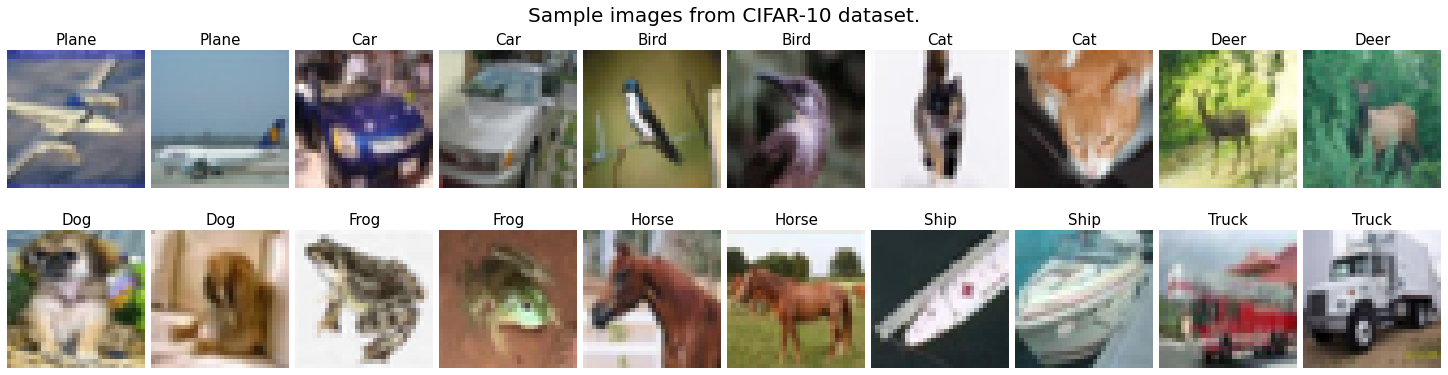

In [24]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show atleast 2 images per class
np.random.seed(0)

dataset = trainloader.dataset
all_labels = dataset.targets
unq_labels = np.unique(all_labels)

indices = []
sampled = []
for i, l in enumerate(unq_labels):
    if l not in sampled:
        indices.extend(np.random.choice(np.where(all_labels == l)[0], 2))
        sampled.append(l)

images = []
labels = []
for i in indices:
    image = dataset.data[i]
    label = dataset.targets[i]
    images.append(image)
    labels.append(label)
        
show_many_images(
    images, grid=(2, 10), figsize=(20, 5),
    subtitles=[classes[x].capitalize() for x in labels],
    save=True, suptitle="Sample images from CIFAR-10 dataset.",
    save_path="./results/cifar_samples.png",
)

####  *` Q2.2: Architecture understanding. Implement architecture of TwolayerNet and ConvNet.`*  

In [26]:
class TwolayerNet(nn.Module):
    # assign layer objects to class attributes
    # nn.init package contains convenient initialization methods
    # http://pytorch.org/docs/master/nn.html#torch-nn-init
    """
    Implements a simple FCN with two layers.
    """
    def __init__(self, num_inputs, num_hidden, num_classes):
        '''
        :param input_size: 3*32*32
        :param hidden_size: decide by yourself e.g. 1024, 512, 128 ...
        :param num_classes: 
        '''
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        
        super(TwolayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden, num_classes)
        
    def forward(self,x):
        # flatten
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.act_fn(x)
        scores = self.linear2(x)
        return scores

In [29]:
class ConvNet(nn.Module):
    """
    Implements a simple ConvNet based on LeNet
    
    Reference: https://ieeexplore.ieee.org/document/726791
    """
    def __init__(
        self, in_channels, num_classes, act="ReLU",
        ckpt_path=None, return_features=False, layer_to_ignore="linear3",
    ):
        """
        Args:
        
        in_channels (int): number of input channels in image
        num_classes (int): number of classes in the dataset
        act (str): activation function to use, default `ReLU`
        ckpt_path (str): path to the checkpoint to load initial weights, optional
        return_features (bool): whether to give a feature extractor network, optional
        layer_to_ignore (str): layer to ignore while loading weights from checkpoint, optional
        """
        super(ConvNet, self).__init__()
        self.ckpt_path = ckpt_path
        self.conv1 = nn.Conv2d(in_channels, out_channels = 6, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)
        self.linear1 = nn.Linear(in_features = 400, out_features = 120)
        self.linear2 = nn.Linear(in_features = 120, out_features = 84)
        self.linear3 = nn.Linear(in_features = 84, out_features = num_classes)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.act_fn = getattr(nn, act)()

        self.return_features = return_features
        self.init_network(self.ckpt_path, layer_to_ignore)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act_fn(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.act_fn(x)
        x = self.pool(x)

        x = x.view(x.size()[0], -1)

        x = self.linear1(x)
        x = self.act_fn(x)
    
        x = self.linear2(x)
        x = self.act_fn(x)

        if self.return_features:
            return x

        x = self.linear3(x)

        return x
    
    def init_network(self, ckpt_path, layer_to_ignore):
        if ckpt_path is None:
            return

        assert exists(ckpt_path), \
            f"Given checkpoint does not exist at {ckpt_path}"
        
        # load ckpt
        ckpt = torch.load(ckpt_path, map_location="cpu")

        # ignore the final layer
        ckpt_state_dict = ckpt.state_dict()
        keys = list(ckpt_state_dict.keys())
        for key in keys:
            if layer_to_ignore is not None:
                if layer_to_ignore in key:
                    del ckpt_state_dict[key]

        self.load_state_dict(ckpt_state_dict, strict=False)

In [33]:
## exmample. You can change and modify it if you like.
## use the above defined trainloader directly and train the models 

## This cell has other useful function (e.g. evaluate) apart from the train function

def fix_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)


def get_device():
    device=torch.device('cpu')
    if torch.cuda.is_available():
        device=torch.device('cuda')
    return device


def evaluate(net, data_loader, loss_fn, epoch, num_epochs, mode="test"):
    """Evalues given model on given dataloader."""

    device = get_device()

    # turn off stuff like drop-out (if it exists)
    net = net.eval()

    y_true = []
    y_pred = []
    loss = 0.0

    iterator = tqdm(
        data_loader,
        f"Evaluate: Epoch [{epoch}/{num_epochs}]", bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
    )
    with torch.no_grad():
        for i, (images, labels) in enumerate(iterator):

            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            batch_loss = loss_fn(outputs, labels).item()
            loss += batch_loss

            # collect predictions
            batch_y_pred = outputs.argmax(1)
            batch_y_true = labels

            if batch_y_pred.device != "cpu":
                batch_y_pred = batch_y_pred.detach()
            if batch_y_true.device != "cpu":
                batch_y_true = batch_y_true.detach()

            y_pred.append(batch_y_pred.cpu().numpy())
            y_true.append(batch_y_true.cpu().numpy())

    # aggregate batch predictions and ground-truth
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    # compute epoch losses and metrics
    loss /= len(data_loader)
    accuracy = np.sum(y_pred == y_true) / len(y_true)

    # log statistics
    print(f'{mode.upper()} \t: Summary: Loss: {loss:.4f} Accuracy: {accuracy:.4f}')

    return loss, accuracy


def train(net, loss_fn, train_loader, valid_loader, num_epochs, opt, sch=None):
    """Trains a given network on given train loader."""
    device = get_device()

    batch_losses = defaultdict(list)
    train_epoch_losses = defaultdict(list)
    train_epoch_metrics = defaultdict(list)
    valid_epoch_losses = defaultdict(list)
    valid_epoch_metrics = defaultdict(list)
    
    epochs = list(range(1, num_epochs + 1))
    for epoch in epochs:

        y_true = []
        y_pred = []

        epoch_loss = 0.0
        epoch_accuracy = 0.0

        iterator = tqdm(
            train_loader,
            f"Training: Epoch [{epoch}/{num_epochs}]", bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
        )
        for i, batch in enumerate(iterator):
            (images, labels) = batch

            images = images.to(device)
            labels = labels.to(device)

            opt.zero_grad()

            outputs = net(images)
            loss = loss_fn(outputs, labels)

            loss.backward()
            opt.step()

            # collect losses
            batch_loss = loss.item()
            batch_losses["loss"].append(batch_loss)
            epoch_loss += batch_loss

            # collect predictions
            batch_y_pred = outputs.argmax(1)
            batch_y_true = labels

            if batch_y_pred.device != "cpu":
                batch_y_pred = batch_y_pred.detach()
            if batch_y_true.device != "cpu":
                batch_y_true = batch_y_true.detach()

            y_pred.append(batch_y_pred.cpu().numpy())
            y_true.append(batch_y_true.cpu().numpy())
        
        if sch is not None:
            sch.step()

        # aggregate batch predictions and ground-truth
        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)

        # collect epoch losses
        epoch_loss /= len(train_loader)
        train_epoch_losses["loss"].append(epoch_loss)

        # compute epoch metrics
        epoch_accuracy = np.sum(y_pred == y_true) / len(y_true)
        train_epoch_metrics["accuracy"].append(epoch_accuracy)

        # compute loss and metrics on the test set
        valid_loss, valid_accuracy = evaluate(net, valid_loader, loss_fn, epoch, num_epochs, mode="valid")
        valid_epoch_losses["loss"].append(valid_loss)
        valid_epoch_metrics["accuracy"].append(valid_accuracy)

        # log epoch statistics
        print(f'TRAIN \t: Summary: Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

    print('Finished Training')
    return epochs, train_epoch_losses, train_epoch_metrics, valid_epoch_losses, valid_epoch_metrics

####  Train Two-layer Net

Selecting 40000 for train.
Selecting 10000 for valid.


Evaluate: Epoch [1/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 275.43it/s]                    


VALID 	: Summary: Loss: 1.6388 Accuracy: 0.4224
TRAIN 	: Summary: Loss: 1.8642 Accuracy: 0.3394


Evaluate: Epoch [2/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.63it/s]                    


VALID 	: Summary: Loss: 1.5756 Accuracy: 0.4406
TRAIN 	: Summary: Loss: 1.7206 Accuracy: 0.3927


Evaluate: Epoch [3/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 240.36it/s]                    


VALID 	: Summary: Loss: 1.5368 Accuracy: 0.4565
TRAIN 	: Summary: Loss: 1.6683 Accuracy: 0.4134


Evaluate: Epoch [4/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 266.31it/s]                    


VALID 	: Summary: Loss: 1.4979 Accuracy: 0.4706
TRAIN 	: Summary: Loss: 1.6379 Accuracy: 0.4267


Evaluate: Epoch [5/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 191.50it/s]                    


VALID 	: Summary: Loss: 1.4759 Accuracy: 0.4747
TRAIN 	: Summary: Loss: 1.6038 Accuracy: 0.4380


Evaluate: Epoch [6/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 273.02it/s]                    


VALID 	: Summary: Loss: 1.4538 Accuracy: 0.4840
TRAIN 	: Summary: Loss: 1.5845 Accuracy: 0.4443


Evaluate: Epoch [7/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.57it/s]                    


VALID 	: Summary: Loss: 1.4469 Accuracy: 0.4845
TRAIN 	: Summary: Loss: 1.5704 Accuracy: 0.4511


Evaluate: Epoch [8/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.78it/s]                    


VALID 	: Summary: Loss: 1.4194 Accuracy: 0.5029
TRAIN 	: Summary: Loss: 1.5466 Accuracy: 0.4566


Evaluate: Epoch [9/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 256.69it/s]                    


VALID 	: Summary: Loss: 1.4114 Accuracy: 0.5031
TRAIN 	: Summary: Loss: 1.5371 Accuracy: 0.4636


Evaluate: Epoch [10/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 266.15it/s]                   


VALID 	: Summary: Loss: 1.3996 Accuracy: 0.5057
TRAIN 	: Summary: Loss: 1.5215 Accuracy: 0.4653
Finished Training


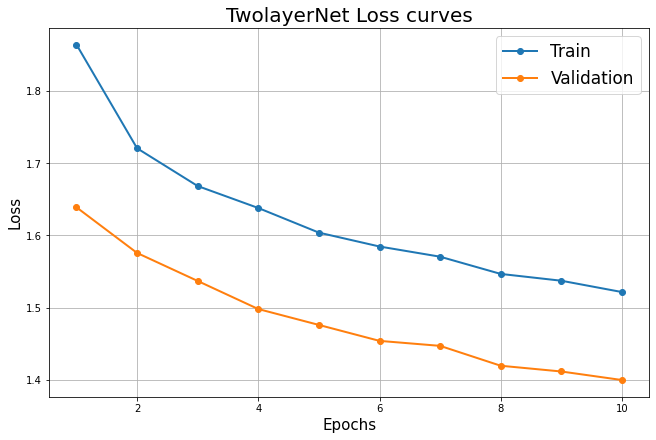

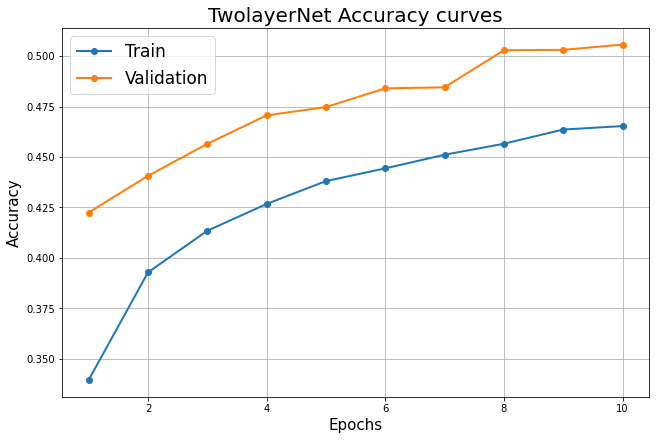

In [40]:
# only training for 10 epochs as a sample
# (our optimal hyperparameters were found with expts run via notebooks in `experiments/` folder)

# define constants
num_epochs = 10 
batch_size = 128

# define transforms (defined in `data/input_transforms.py`)
train_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
    {
        "name": "RandomHorizontalFlip",
        "args": {"p": 0.5},
    },
    {
        "name": "GaussianBlur",
        "args": {"kernel_size": 3},
    },
]
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

# define the datasets
train_transform = InputTransform(train_transforms)
valid_transform = InputTransform(valid_transforms)
# we split training set into: 80% train and 20% val
train_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="train", transform=train_transform)
valid_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="valid", transform=valid_transform)
test_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="test", transform=valid_transform)

# obtain the train dataloader
train_loader = get_dataloader(train_dataset, train=True, batch_size=batch_size, num_workers=0)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=batch_size, num_workers=0)
test_loader = get_dataloader(test_dataset, train=False, batch_size=batch_size, num_workers=0)

net = TwolayerNet(num_inputs=3 * 32 * 32, num_hidden=512, num_classes=10)
arch = type(net).__name__

# define the optimizer and scheduler
opt_args = {"name": "Adam", "lr": 1e-4}
opt = optimizer(model_params=net.parameters(), **opt_args)
sch_args = {"name": "MultiStepLR", "milestones": [50, 100, 150], "gamma": 0.5}
sch = scheduler(opt=opt, **sch_args)

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs, train_losses, train_metrics, valid_losses, valid_metrics = train(
    net, loss_fn, train_loader, valid_loader, num_epochs=num_epochs, opt=opt, sch=sch,
)

# plot training curves
plot_multiple_quantities_by_time(
    quantities=[train_losses["loss"], valid_losses["loss"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Loss curves",
    show=True,
    save=False,
    save_path="../results/tln_best_plot_best.png",
    ylabel="Loss",
)
plot_multiple_quantities_by_time(
    quantities=[train_metrics["accuracy"], valid_metrics["accuracy"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Accuracy curves",
    show=True,
    save=False,
    save_path="../results/tln_accu_plot_best.png",
    ylabel="Accuracy",
)

#### Train ConvNet - LeNet-5

Selecting 40000 for train.
Selecting 10000 for valid.


Evaluate: Epoch [1/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 149.81it/s]                    


VALID 	: Summary: Loss: 1.6533 Accuracy: 0.3910
TRAIN 	: Summary: Loss: 1.9031 Accuracy: 0.2998


Evaluate: Epoch [2/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 133.50it/s]                    


VALID 	: Summary: Loss: 1.4876 Accuracy: 0.4582
TRAIN 	: Summary: Loss: 1.6642 Accuracy: 0.3947


Evaluate: Epoch [3/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 149.70it/s]                    


VALID 	: Summary: Loss: 1.3991 Accuracy: 0.4936
TRAIN 	: Summary: Loss: 1.5445 Accuracy: 0.4365


Evaluate: Epoch [4/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 136.46it/s]                    


VALID 	: Summary: Loss: 1.3528 Accuracy: 0.5138
TRAIN 	: Summary: Loss: 1.4827 Accuracy: 0.4646


Evaluate: Epoch [5/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 109.99it/s]                    


VALID 	: Summary: Loss: 1.3242 Accuracy: 0.5134
TRAIN 	: Summary: Loss: 1.4421 Accuracy: 0.4787


Evaluate: Epoch [6/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 148.12it/s]                    


VALID 	: Summary: Loss: 1.3543 Accuracy: 0.5094
TRAIN 	: Summary: Loss: 1.4083 Accuracy: 0.4930


Evaluate: Epoch [7/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 146.27it/s]                    


VALID 	: Summary: Loss: 1.2706 Accuracy: 0.5458
TRAIN 	: Summary: Loss: 1.3820 Accuracy: 0.5036


Evaluate: Epoch [8/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.78it/s]                    


VALID 	: Summary: Loss: 1.2475 Accuracy: 0.5531
TRAIN 	: Summary: Loss: 1.3548 Accuracy: 0.5119


Evaluate: Epoch [9/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.02it/s]                    


VALID 	: Summary: Loss: 1.2218 Accuracy: 0.5612
TRAIN 	: Summary: Loss: 1.3352 Accuracy: 0.5218


Evaluate: Epoch [10/10]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.28it/s]                   


VALID 	: Summary: Loss: 1.1999 Accuracy: 0.5675
TRAIN 	: Summary: Loss: 1.3138 Accuracy: 0.5279
Finished Training


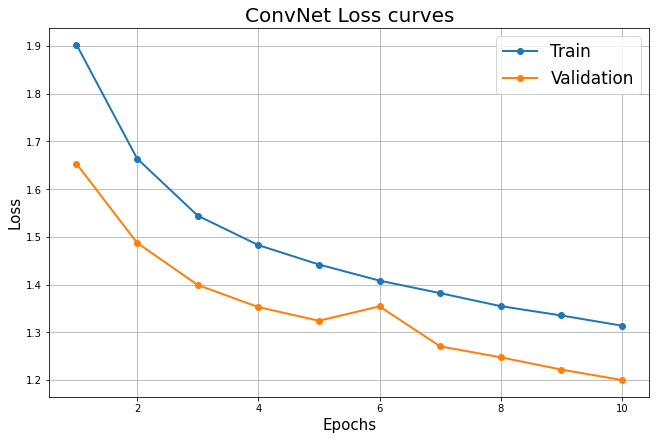

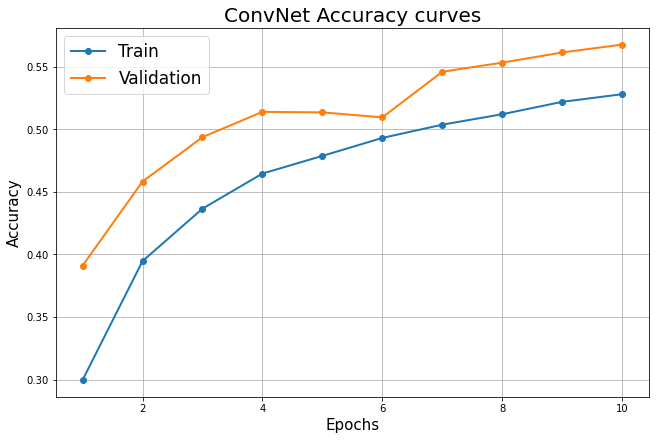

In [41]:
# only training for 10 epochs as a sample
# (our optimal hyperparameters were found with expts run via notebooks in `experiments/` folder)

# define constants
num_epochs = 10 
batch_size = 128

# define transforms (defined in `data/input_transforms.py`)
train_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
]
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

# define the datasets
train_transform = InputTransform(train_transforms)
valid_transform = InputTransform(valid_transforms)
# we split training set into: 80% train and 20% val
train_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="train", transform=train_transform)
valid_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="valid", transform=valid_transform)
test_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="test", transform=valid_transform)

# obtain the train dataloader
train_loader = get_dataloader(train_dataset, train=True, batch_size=batch_size, num_workers=0)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=batch_size, num_workers=0)
test_loader = get_dataloader(test_dataset, train=False, batch_size=batch_size, num_workers=0)

net = ConvNet(in_channels=3, num_classes=10)
arch = type(net).__name__

# define the optimizer and scheduler
opt_args = {"name": "Adam", "lr": 1e-3}
opt = optimizer(model_params=net.parameters(), **opt_args)
sch_args = {"name": "MultiStepLR", "milestones": [50], "gamma": 0.5}
sch = scheduler(opt=opt, **sch_args)

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs, train_losses, train_metrics, valid_losses, valid_metrics = train(
    net, loss_fn, train_loader, valid_loader, num_epochs=num_epochs, opt=opt, sch=sch,
)

# plot training curves
plot_multiple_quantities_by_time(
    quantities=[train_losses["loss"], valid_losses["loss"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Loss curves",
    show=True,
    save=False,
    save_path="../results/tln_best_plot_best.png",
    ylabel="Loss",
)
plot_multiple_quantities_by_time(
    quantities=[train_metrics["accuracy"], valid_metrics["accuracy"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Accuracy curves",
    show=True,
    save=False,
    save_path="../results/tln_accu_plot_best.png",
    ylabel="Accuracy",
)

In [42]:
def valid(net,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

In [44]:
valid(net, valid_loader)

Accuracy of the network on the 10000 test images: 56 %


In [43]:
def valid_class(net,testloader,classes):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [46]:
valid_class(net, valid_loader, classes)

Accuracy of plane : 36 %
Accuracy of   car : 69 %
Accuracy of  bird : 32 %
Accuracy of   cat : 34 %
Accuracy of  deer : 56 %
Accuracy of   dog : 44 %
Accuracy of  frog : 61 %
Accuracy of horse : 76 %
Accuracy of  ship : 73 %
Accuracy of truck : 77 %


####  *` Q2.3: Preparation of training. Create Dataloader yourself and define Transform, optimizer.`*  

#### *` Complement  CIFAR10_loader()`*

In [51]:
###  we originally have written this in script `data/cifar.py`

class CIFAR(Dataset):
    """Defines the CIFAR dataset class."""

    def __init__(self, root, mode="train", transform=None) -> None:
        assert mode in ["train", "valid", "test"], \
            "Possible values for mode: ['train', 'valid', 'test']"

        self.root = root
        self.mode = mode
        self.transform = transform

        # load images and targets
        self.load_data(root, mode)

        # sample images (split into train/valid)
        self.select_samples(mode)

    def load_data(self, root, mode):
        pattern = "data_batch_*" if mode in ["train", "valid"] else "test_batch"
        data_pkls = glob(join(root, "cifar-10-batches-py", pattern))

        self.data = []
        self.targets = []

        for pkl in data_pkls:
            data_dict = unpickle(pkl)

            self.data.extend(data_dict[b"data"])
            self.targets.extend(data_dict[b"labels"])

        self.targets = np.array(self.targets)
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))
    
    def select_samples(self, mode, train_fraction=0.8):
        if mode in ["train", "valid"]:
            num_samples = len(self.data)
            indices = np.array(range(num_samples))
            fraction = train_fraction if mode == "train" else (1 - train_fraction)
            num_train_samples = int(train_fraction * num_samples)

            train_indices = np.arange(0, num_train_samples, 1)
            valid_indices = np.arange(num_train_samples, num_samples, 1)
            select_indices = train_indices if mode == "train" else valid_indices
            print(f"Selecting {len(select_indices)} for {mode}.")

            self.data = self.data[select_indices]
            self.targets = self.targets[select_indices]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        # get sample at index = item
        img, target = self.data[item], self.targets[item]

        # transform the input (e.g. augmentations apply here)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

#### *` Complement Transform function and Optimizer`*

In [53]:
# define transforms (defined in `data/input_transforms.py`)

transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
]
transform_train = InputTransform(transforms)


transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
transform_test = InputTransform(transforms)

# define optimizer and scheduler
# originally defined in models/optimizer.py

def optimizer(name:str, model_params: dict, **kwargs):
    """Defines an optimizer."""
    assert name in ["SGD", "Adam", "AdamW"]
    opt = eval(name)(params=model_params, **kwargs)
    return opt


def scheduler(opt, name: str, **kwargs):
    """Defines LR scheduler."""
    assert name in ["StepLR", "MultiStepLR", "ExponentialLR"]
    sch = eval(name)(opt, **kwargs)
    return sch

#### *` Train the ConvNet with CIFAR10_loader, transform and optimizer you implemented and compare the results`*

In [54]:
# the previously defined `train()` function shall suffice here

# def train(net, trainloader,epoch=1):
#     ###################### Define Loss function and optimizer
    
#     ############################### Training
#     for epoch in range(epoch):  # loop over the dataset multiple times 

#         ################################
#         # Todo: finish the code
#         ################################

#     print('Finished Training')

#### *` Q2.4 Setting up the hyperparameters.`*

#### *`Play with convNet and TwolayerNet, set up the hyperparameters and reach the accuracy as high as you can`*

In [57]:
def experiment(train_transforms, valid_transforms, network, num_epochs, batch_size, opt_args, sch_args=None):
    """Single function to run an experiment with given hyperparameters."""
    
    # define the datasets
    train_transform = InputTransform(train_transforms)
    valid_transform = InputTransform(valid_transforms)
    train_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="train", transform=train_transform)
    valid_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="valid", transform=valid_transform)

    # obtain the train dataloader
    train_loader = get_dataloader(train_dataset, train=True, batch_size=batch_size, num_workers=0)
    valid_loader = get_dataloader(valid_dataset, train=False, batch_size=batch_size, num_workers=0)

    if network == "tln":
        net = TwolayerNet(num_inputs=3 * 32 * 32, num_hidden=512, num_classes=10)
    elif network == "cnn":
        net = ConvNet(in_channels=3, num_classes=10)
    else:
        raise ValueError()
    arch = type(net).__name__

    # define the optimizer and scheduler
    opt = optimizer(model_params=net.parameters(), **opt_args)
    sch = None
    if sch_args is not None:
        sch = scheduler(opt=opt, **sch_args)

    # define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # train the model
    epochs, train_losses, train_metrics, valid_losses, valid_metrics = train(
        net, loss_fn, train_loader, valid_loader, num_epochs=num_epochs, opt=opt, sch=sch,
    )

    # plot training curves
    plot_multiple_quantities_by_time(
        quantities=[train_losses["loss"], valid_losses["loss"]],
        time=epochs,
        labels=["Train", "Validation"],
        title=f"{arch} Loss curves",
        show=True,
        save=True,
        save_path="../results/cnn_loss_plot_best.png",
        ylabel="Loss",
    )
    plot_multiple_quantities_by_time(
        quantities=[train_metrics["accuracy"], valid_metrics["accuracy"]],
        time=epochs,
        labels=["Train", "Validation"],
        title=f"{arch} Accuracy curves",
        show=True,
        save=True,
        save_path="../results/cnn_accu_plot_best.png",
        ylabel="Accuracy",
    )
    
    return net, loss_fn

Selecting 40000 for train.
Selecting 10000 for valid.


Evaluate: Epoch [1/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 256.87it/s]                   


VALID 	: Summary: Loss: 1.6461 Accuracy: 0.4204
TRAIN 	: Summary: Loss: 1.8638 Accuracy: 0.3401


Evaluate: Epoch [2/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 266.42it/s]                   


VALID 	: Summary: Loss: 1.5781 Accuracy: 0.4414
TRAIN 	: Summary: Loss: 1.7199 Accuracy: 0.3937


Evaluate: Epoch [3/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.86it/s]                   


VALID 	: Summary: Loss: 1.5300 Accuracy: 0.4603
TRAIN 	: Summary: Loss: 1.6669 Accuracy: 0.4166


Evaluate: Epoch [4/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.00it/s]                   


VALID 	: Summary: Loss: 1.5213 Accuracy: 0.4605
TRAIN 	: Summary: Loss: 1.6340 Accuracy: 0.4258


Evaluate: Epoch [5/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 250.78it/s]                   


VALID 	: Summary: Loss: 1.4699 Accuracy: 0.4796
TRAIN 	: Summary: Loss: 1.6053 Accuracy: 0.4361


Evaluate: Epoch [6/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.23it/s]                   


VALID 	: Summary: Loss: 1.4650 Accuracy: 0.4833
TRAIN 	: Summary: Loss: 1.5866 Accuracy: 0.4456


Evaluate: Epoch [7/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 274.72it/s]                   


VALID 	: Summary: Loss: 1.4509 Accuracy: 0.4885
TRAIN 	: Summary: Loss: 1.5664 Accuracy: 0.4501


Evaluate: Epoch [8/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.26it/s]                   


VALID 	: Summary: Loss: 1.4240 Accuracy: 0.4955
TRAIN 	: Summary: Loss: 1.5507 Accuracy: 0.4570


Evaluate: Epoch [9/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 277.45it/s]                   


VALID 	: Summary: Loss: 1.4030 Accuracy: 0.5033
TRAIN 	: Summary: Loss: 1.5371 Accuracy: 0.4640


Evaluate: Epoch [10/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 241.40it/s]                  


VALID 	: Summary: Loss: 1.3999 Accuracy: 0.5018
TRAIN 	: Summary: Loss: 1.5270 Accuracy: 0.4640


Evaluate: Epoch [11/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 276.60it/s]                  


VALID 	: Summary: Loss: 1.3864 Accuracy: 0.5100
TRAIN 	: Summary: Loss: 1.5136 Accuracy: 0.4704


Evaluate: Epoch [12/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 271.75it/s]                  


VALID 	: Summary: Loss: 1.3818 Accuracy: 0.5087
TRAIN 	: Summary: Loss: 1.5062 Accuracy: 0.4741


Evaluate: Epoch [13/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.99it/s]                  


VALID 	: Summary: Loss: 1.3728 Accuracy: 0.5176
TRAIN 	: Summary: Loss: 1.4924 Accuracy: 0.4782


Evaluate: Epoch [14/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 260.93it/s]                  


VALID 	: Summary: Loss: 1.3627 Accuracy: 0.5125
TRAIN 	: Summary: Loss: 1.4846 Accuracy: 0.4819


Evaluate: Epoch [15/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.52it/s]                  


VALID 	: Summary: Loss: 1.3595 Accuracy: 0.5200
TRAIN 	: Summary: Loss: 1.4809 Accuracy: 0.4820


Evaluate: Epoch [16/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 271.20it/s]                  


VALID 	: Summary: Loss: 1.3618 Accuracy: 0.5197
TRAIN 	: Summary: Loss: 1.4726 Accuracy: 0.4859


Evaluate: Epoch [17/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.64it/s]                  


VALID 	: Summary: Loss: 1.3482 Accuracy: 0.5234
TRAIN 	: Summary: Loss: 1.4597 Accuracy: 0.4899


Evaluate: Epoch [18/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 274.55it/s]                  


VALID 	: Summary: Loss: 1.3434 Accuracy: 0.5278
TRAIN 	: Summary: Loss: 1.4557 Accuracy: 0.4910


Evaluate: Epoch [19/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 271.78it/s]                  


VALID 	: Summary: Loss: 1.3348 Accuracy: 0.5277
TRAIN 	: Summary: Loss: 1.4488 Accuracy: 0.4944


Evaluate: Epoch [20/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 270.99it/s]                  


VALID 	: Summary: Loss: 1.3294 Accuracy: 0.5307
TRAIN 	: Summary: Loss: 1.4426 Accuracy: 0.4957


Evaluate: Epoch [21/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 271.78it/s]                  


VALID 	: Summary: Loss: 1.3330 Accuracy: 0.5309
TRAIN 	: Summary: Loss: 1.4356 Accuracy: 0.4958


Evaluate: Epoch [22/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.42it/s]                  


VALID 	: Summary: Loss: 1.3231 Accuracy: 0.5359
TRAIN 	: Summary: Loss: 1.4344 Accuracy: 0.4987


Evaluate: Epoch [23/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 265.94it/s]                  


VALID 	: Summary: Loss: 1.3150 Accuracy: 0.5365
TRAIN 	: Summary: Loss: 1.4253 Accuracy: 0.5026


Evaluate: Epoch [24/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.69it/s]                  


VALID 	: Summary: Loss: 1.3045 Accuracy: 0.5416
TRAIN 	: Summary: Loss: 1.4175 Accuracy: 0.5061


Evaluate: Epoch [25/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 253.96it/s]                  


VALID 	: Summary: Loss: 1.3003 Accuracy: 0.5408
TRAIN 	: Summary: Loss: 1.4142 Accuracy: 0.5072


Evaluate: Epoch [26/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.16it/s]                  


VALID 	: Summary: Loss: 1.2970 Accuracy: 0.5444
TRAIN 	: Summary: Loss: 1.4153 Accuracy: 0.5032


Evaluate: Epoch [27/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 233.28it/s]                  


VALID 	: Summary: Loss: 1.2959 Accuracy: 0.5441
TRAIN 	: Summary: Loss: 1.4077 Accuracy: 0.5072


Evaluate: Epoch [28/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 247.80it/s]                  


VALID 	: Summary: Loss: 1.2974 Accuracy: 0.5446
TRAIN 	: Summary: Loss: 1.4031 Accuracy: 0.5090


Evaluate: Epoch [29/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 275.84it/s]                  


VALID 	: Summary: Loss: 1.2898 Accuracy: 0.5465
TRAIN 	: Summary: Loss: 1.3992 Accuracy: 0.5113


Evaluate: Epoch [30/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 231.69it/s]                  


VALID 	: Summary: Loss: 1.2971 Accuracy: 0.5432
TRAIN 	: Summary: Loss: 1.3923 Accuracy: 0.5130


Evaluate: Epoch [31/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 254.58it/s]                  


VALID 	: Summary: Loss: 1.2811 Accuracy: 0.5497
TRAIN 	: Summary: Loss: 1.3942 Accuracy: 0.5128


Evaluate: Epoch [32/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.00it/s]                  


VALID 	: Summary: Loss: 1.2713 Accuracy: 0.5548
TRAIN 	: Summary: Loss: 1.3872 Accuracy: 0.5150


Evaluate: Epoch [33/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 247.36it/s]                  


VALID 	: Summary: Loss: 1.2786 Accuracy: 0.5515
TRAIN 	: Summary: Loss: 1.3826 Accuracy: 0.5184


Evaluate: Epoch [34/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 272.94it/s]                  


VALID 	: Summary: Loss: 1.2818 Accuracy: 0.5504
TRAIN 	: Summary: Loss: 1.3828 Accuracy: 0.5150


Evaluate: Epoch [35/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 240.55it/s]                  


VALID 	: Summary: Loss: 1.2740 Accuracy: 0.5526
TRAIN 	: Summary: Loss: 1.3760 Accuracy: 0.5163


Evaluate: Epoch [36/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 234.16it/s]                  


VALID 	: Summary: Loss: 1.2697 Accuracy: 0.5547
TRAIN 	: Summary: Loss: 1.3713 Accuracy: 0.5194


Evaluate: Epoch [37/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 276.77it/s]                  


VALID 	: Summary: Loss: 1.2573 Accuracy: 0.5599
TRAIN 	: Summary: Loss: 1.3709 Accuracy: 0.5216


Evaluate: Epoch [38/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 272.98it/s]                  


VALID 	: Summary: Loss: 1.2561 Accuracy: 0.5588
TRAIN 	: Summary: Loss: 1.3622 Accuracy: 0.5248


Evaluate: Epoch [39/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 255.16it/s]                  


VALID 	: Summary: Loss: 1.2662 Accuracy: 0.5565
TRAIN 	: Summary: Loss: 1.3608 Accuracy: 0.5243


Evaluate: Epoch [40/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 275.87it/s]                  


VALID 	: Summary: Loss: 1.2540 Accuracy: 0.5644
TRAIN 	: Summary: Loss: 1.3585 Accuracy: 0.5239


Evaluate: Epoch [41/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.28it/s]                  


VALID 	: Summary: Loss: 1.2476 Accuracy: 0.5649
TRAIN 	: Summary: Loss: 1.3564 Accuracy: 0.5284


Evaluate: Epoch [42/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 273.57it/s]                  


VALID 	: Summary: Loss: 1.2483 Accuracy: 0.5634
TRAIN 	: Summary: Loss: 1.3523 Accuracy: 0.5272


Evaluate: Epoch [43/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 255.60it/s]                  


VALID 	: Summary: Loss: 1.2564 Accuracy: 0.5592
TRAIN 	: Summary: Loss: 1.3491 Accuracy: 0.5300


Evaluate: Epoch [44/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 257.59it/s]                  


VALID 	: Summary: Loss: 1.2434 Accuracy: 0.5644
TRAIN 	: Summary: Loss: 1.3519 Accuracy: 0.5289


Evaluate: Epoch [45/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.32it/s]                  


VALID 	: Summary: Loss: 1.2390 Accuracy: 0.5667
TRAIN 	: Summary: Loss: 1.3427 Accuracy: 0.5326


Evaluate: Epoch [46/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 255.94it/s]                  


VALID 	: Summary: Loss: 1.2386 Accuracy: 0.5673
TRAIN 	: Summary: Loss: 1.3395 Accuracy: 0.5342


Evaluate: Epoch [47/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 257.56it/s]                  


VALID 	: Summary: Loss: 1.2306 Accuracy: 0.5692
TRAIN 	: Summary: Loss: 1.3425 Accuracy: 0.5331


Evaluate: Epoch [48/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 271.64it/s]                  


VALID 	: Summary: Loss: 1.2324 Accuracy: 0.5652
TRAIN 	: Summary: Loss: 1.3334 Accuracy: 0.5360


Evaluate: Epoch [49/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.09it/s]                  


VALID 	: Summary: Loss: 1.2275 Accuracy: 0.5742
TRAIN 	: Summary: Loss: 1.3370 Accuracy: 0.5330


Evaluate: Epoch [50/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 270.81it/s]                  


VALID 	: Summary: Loss: 1.2325 Accuracy: 0.5711
TRAIN 	: Summary: Loss: 1.3337 Accuracy: 0.5349


Evaluate: Epoch [51/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.74it/s]                  


VALID 	: Summary: Loss: 1.2179 Accuracy: 0.5744
TRAIN 	: Summary: Loss: 1.3132 Accuracy: 0.5416


Evaluate: Epoch [52/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.91it/s]                  


VALID 	: Summary: Loss: 1.2211 Accuracy: 0.5715
TRAIN 	: Summary: Loss: 1.3149 Accuracy: 0.5432


Evaluate: Epoch [53/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.20it/s]                  


VALID 	: Summary: Loss: 1.2154 Accuracy: 0.5774
TRAIN 	: Summary: Loss: 1.3111 Accuracy: 0.5438


Evaluate: Epoch [54/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.34it/s]                  


VALID 	: Summary: Loss: 1.2188 Accuracy: 0.5759
TRAIN 	: Summary: Loss: 1.3089 Accuracy: 0.5470


Evaluate: Epoch [55/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.10it/s]                  


VALID 	: Summary: Loss: 1.2063 Accuracy: 0.5794
TRAIN 	: Summary: Loss: 1.3069 Accuracy: 0.5466


Evaluate: Epoch [56/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.76it/s]                  


VALID 	: Summary: Loss: 1.2103 Accuracy: 0.5824
TRAIN 	: Summary: Loss: 1.3069 Accuracy: 0.5463


Evaluate: Epoch [57/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 266.59it/s]                  


VALID 	: Summary: Loss: 1.2004 Accuracy: 0.5834
TRAIN 	: Summary: Loss: 1.3012 Accuracy: 0.5477


Evaluate: Epoch [58/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 272.64it/s]                  


VALID 	: Summary: Loss: 1.2082 Accuracy: 0.5774
TRAIN 	: Summary: Loss: 1.3007 Accuracy: 0.5464


Evaluate: Epoch [59/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.13it/s]                  


VALID 	: Summary: Loss: 1.2038 Accuracy: 0.5826
TRAIN 	: Summary: Loss: 1.2987 Accuracy: 0.5530


Evaluate: Epoch [60/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 266.75it/s]                  


VALID 	: Summary: Loss: 1.2069 Accuracy: 0.5813
TRAIN 	: Summary: Loss: 1.2986 Accuracy: 0.5472


Evaluate: Epoch [61/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.58it/s]                  


VALID 	: Summary: Loss: 1.2025 Accuracy: 0.5829
TRAIN 	: Summary: Loss: 1.2990 Accuracy: 0.5485


Evaluate: Epoch [62/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.39it/s]                  


VALID 	: Summary: Loss: 1.1972 Accuracy: 0.5841
TRAIN 	: Summary: Loss: 1.2952 Accuracy: 0.5505


Evaluate: Epoch [63/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 243.25it/s]                  


VALID 	: Summary: Loss: 1.2057 Accuracy: 0.5811
TRAIN 	: Summary: Loss: 1.2945 Accuracy: 0.5499


Evaluate: Epoch [64/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 199.93it/s]                  


VALID 	: Summary: Loss: 1.1973 Accuracy: 0.5813
TRAIN 	: Summary: Loss: 1.2954 Accuracy: 0.5493


Evaluate: Epoch [65/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 255.92it/s]                  


VALID 	: Summary: Loss: 1.2047 Accuracy: 0.5789
TRAIN 	: Summary: Loss: 1.2909 Accuracy: 0.5522


Evaluate: Epoch [66/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 271.26it/s]                  


VALID 	: Summary: Loss: 1.1967 Accuracy: 0.5825
TRAIN 	: Summary: Loss: 1.2895 Accuracy: 0.5512


Evaluate: Epoch [67/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 233.15it/s]                  


VALID 	: Summary: Loss: 1.1951 Accuracy: 0.5852
TRAIN 	: Summary: Loss: 1.2946 Accuracy: 0.5483


Evaluate: Epoch [68/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 260.62it/s]                  


VALID 	: Summary: Loss: 1.1968 Accuracy: 0.5819
TRAIN 	: Summary: Loss: 1.2876 Accuracy: 0.5525


Evaluate: Epoch [69/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 218.77it/s]                  


VALID 	: Summary: Loss: 1.1901 Accuracy: 0.5866
TRAIN 	: Summary: Loss: 1.2832 Accuracy: 0.5546


Evaluate: Epoch [70/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.58it/s]                  


VALID 	: Summary: Loss: 1.1925 Accuracy: 0.5855
TRAIN 	: Summary: Loss: 1.2866 Accuracy: 0.5528


Evaluate: Epoch [71/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 255.84it/s]                  


VALID 	: Summary: Loss: 1.1857 Accuracy: 0.5879
TRAIN 	: Summary: Loss: 1.2832 Accuracy: 0.5553


Evaluate: Epoch [72/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.73it/s]                  


VALID 	: Summary: Loss: 1.1900 Accuracy: 0.5854
TRAIN 	: Summary: Loss: 1.2825 Accuracy: 0.5556


Evaluate: Epoch [73/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.46it/s]                  


VALID 	: Summary: Loss: 1.1915 Accuracy: 0.5847
TRAIN 	: Summary: Loss: 1.2811 Accuracy: 0.5514


Evaluate: Epoch [74/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 265.10it/s]                  


VALID 	: Summary: Loss: 1.1885 Accuracy: 0.5861
TRAIN 	: Summary: Loss: 1.2813 Accuracy: 0.5564


Evaluate: Epoch [75/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 241.51it/s]                  


VALID 	: Summary: Loss: 1.1906 Accuracy: 0.5867
TRAIN 	: Summary: Loss: 1.2787 Accuracy: 0.5562


Evaluate: Epoch [76/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 256.46it/s]                  


VALID 	: Summary: Loss: 1.1871 Accuracy: 0.5839
TRAIN 	: Summary: Loss: 1.2802 Accuracy: 0.5575


Evaluate: Epoch [77/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 235.84it/s]                  


VALID 	: Summary: Loss: 1.1906 Accuracy: 0.5864
TRAIN 	: Summary: Loss: 1.2772 Accuracy: 0.5583


Evaluate: Epoch [78/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.71it/s]                  


VALID 	: Summary: Loss: 1.1888 Accuracy: 0.5863
TRAIN 	: Summary: Loss: 1.2742 Accuracy: 0.5580


Evaluate: Epoch [79/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 219.43it/s]                  


VALID 	: Summary: Loss: 1.1875 Accuracy: 0.5897
TRAIN 	: Summary: Loss: 1.2779 Accuracy: 0.5578


Evaluate: Epoch [80/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.09it/s]                  


VALID 	: Summary: Loss: 1.1831 Accuracy: 0.5877
TRAIN 	: Summary: Loss: 1.2767 Accuracy: 0.5558


Evaluate: Epoch [81/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 257.68it/s]                  


VALID 	: Summary: Loss: 1.1805 Accuracy: 0.5907
TRAIN 	: Summary: Loss: 1.2743 Accuracy: 0.5585


Evaluate: Epoch [82/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 265.22it/s]                  


VALID 	: Summary: Loss: 1.1885 Accuracy: 0.5877
TRAIN 	: Summary: Loss: 1.2760 Accuracy: 0.5560


Evaluate: Epoch [83/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.52it/s]                  


VALID 	: Summary: Loss: 1.1813 Accuracy: 0.5901
TRAIN 	: Summary: Loss: 1.2700 Accuracy: 0.5585


Evaluate: Epoch [84/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 247.56it/s]                  


VALID 	: Summary: Loss: 1.1815 Accuracy: 0.5866
TRAIN 	: Summary: Loss: 1.2677 Accuracy: 0.5605


Evaluate: Epoch [85/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 238.22it/s]                  


VALID 	: Summary: Loss: 1.1756 Accuracy: 0.5897
TRAIN 	: Summary: Loss: 1.2703 Accuracy: 0.5597


Evaluate: Epoch [86/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 246.65it/s]                  


VALID 	: Summary: Loss: 1.1780 Accuracy: 0.5892
TRAIN 	: Summary: Loss: 1.2676 Accuracy: 0.5595


Evaluate: Epoch [87/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.51it/s]                  


VALID 	: Summary: Loss: 1.1763 Accuracy: 0.5937
TRAIN 	: Summary: Loss: 1.2681 Accuracy: 0.5607


Evaluate: Epoch [88/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.73it/s]                  


VALID 	: Summary: Loss: 1.1799 Accuracy: 0.5916
TRAIN 	: Summary: Loss: 1.2669 Accuracy: 0.5602


Evaluate: Epoch [89/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 272.82it/s]                  


VALID 	: Summary: Loss: 1.1785 Accuracy: 0.5888
TRAIN 	: Summary: Loss: 1.2622 Accuracy: 0.5625


Evaluate: Epoch [90/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.46it/s]                  


VALID 	: Summary: Loss: 1.1792 Accuracy: 0.5911
TRAIN 	: Summary: Loss: 1.2659 Accuracy: 0.5614


Evaluate: Epoch [91/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.57it/s]                  


VALID 	: Summary: Loss: 1.1821 Accuracy: 0.5930
TRAIN 	: Summary: Loss: 1.2627 Accuracy: 0.5636


Evaluate: Epoch [92/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.90it/s]                  


VALID 	: Summary: Loss: 1.1760 Accuracy: 0.5943
TRAIN 	: Summary: Loss: 1.2639 Accuracy: 0.5610


Evaluate: Epoch [93/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 273.48it/s]                  


VALID 	: Summary: Loss: 1.1773 Accuracy: 0.5921
TRAIN 	: Summary: Loss: 1.2593 Accuracy: 0.5647


Evaluate: Epoch [94/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.25it/s]                  


VALID 	: Summary: Loss: 1.1722 Accuracy: 0.5899
TRAIN 	: Summary: Loss: 1.2659 Accuracy: 0.5616


Evaluate: Epoch [95/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.35it/s]                  


VALID 	: Summary: Loss: 1.1711 Accuracy: 0.5907
TRAIN 	: Summary: Loss: 1.2588 Accuracy: 0.5638


Evaluate: Epoch [96/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.18it/s]                  


VALID 	: Summary: Loss: 1.1760 Accuracy: 0.5925
TRAIN 	: Summary: Loss: 1.2591 Accuracy: 0.5624


Evaluate: Epoch [97/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 269.97it/s]                  


VALID 	: Summary: Loss: 1.1811 Accuracy: 0.5865
TRAIN 	: Summary: Loss: 1.2587 Accuracy: 0.5639


Evaluate: Epoch [98/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.84it/s]                  


VALID 	: Summary: Loss: 1.1702 Accuracy: 0.5949
TRAIN 	: Summary: Loss: 1.2622 Accuracy: 0.5596


Evaluate: Epoch [99/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 273.00it/s]                  


VALID 	: Summary: Loss: 1.1697 Accuracy: 0.5948
TRAIN 	: Summary: Loss: 1.2540 Accuracy: 0.5675


Evaluate: Epoch [100/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.39it/s]                 


VALID 	: Summary: Loss: 1.1671 Accuracy: 0.5950
TRAIN 	: Summary: Loss: 1.2550 Accuracy: 0.5670


Evaluate: Epoch [101/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 273.34it/s]                 


VALID 	: Summary: Loss: 1.1620 Accuracy: 0.5979
TRAIN 	: Summary: Loss: 1.2491 Accuracy: 0.5662


Evaluate: Epoch [102/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 250.01it/s]                 


VALID 	: Summary: Loss: 1.1606 Accuracy: 0.5984
TRAIN 	: Summary: Loss: 1.2436 Accuracy: 0.5691


Evaluate: Epoch [103/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 266.68it/s]                 


VALID 	: Summary: Loss: 1.1666 Accuracy: 0.5955
TRAIN 	: Summary: Loss: 1.2433 Accuracy: 0.5715


Evaluate: Epoch [104/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.15it/s]                 


VALID 	: Summary: Loss: 1.1603 Accuracy: 0.5959
TRAIN 	: Summary: Loss: 1.2466 Accuracy: 0.5683


Evaluate: Epoch [105/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 259.30it/s]                 


VALID 	: Summary: Loss: 1.1575 Accuracy: 0.6000
TRAIN 	: Summary: Loss: 1.2397 Accuracy: 0.5725


Evaluate: Epoch [106/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 265.00it/s]                 


VALID 	: Summary: Loss: 1.1585 Accuracy: 0.5991
TRAIN 	: Summary: Loss: 1.2435 Accuracy: 0.5705


Evaluate: Epoch [107/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 260.93it/s]                 


VALID 	: Summary: Loss: 1.1576 Accuracy: 0.6021
TRAIN 	: Summary: Loss: 1.2433 Accuracy: 0.5692


Evaluate: Epoch [108/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 275.57it/s]                 


VALID 	: Summary: Loss: 1.1551 Accuracy: 0.6007
TRAIN 	: Summary: Loss: 1.2440 Accuracy: 0.5666


Evaluate: Epoch [109/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 253.48it/s]                 


VALID 	: Summary: Loss: 1.1538 Accuracy: 0.6006
TRAIN 	: Summary: Loss: 1.2420 Accuracy: 0.5688


Evaluate: Epoch [110/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 236.81it/s]                 


VALID 	: Summary: Loss: 1.1582 Accuracy: 0.5988
TRAIN 	: Summary: Loss: 1.2381 Accuracy: 0.5709


Evaluate: Epoch [111/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.57it/s]                 


VALID 	: Summary: Loss: 1.1578 Accuracy: 0.6022
TRAIN 	: Summary: Loss: 1.2425 Accuracy: 0.5684


Evaluate: Epoch [112/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 249.63it/s]                 


VALID 	: Summary: Loss: 1.1540 Accuracy: 0.6004
TRAIN 	: Summary: Loss: 1.2357 Accuracy: 0.5744


Evaluate: Epoch [113/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 224.70it/s]                 


VALID 	: Summary: Loss: 1.1562 Accuracy: 0.6007
TRAIN 	: Summary: Loss: 1.2406 Accuracy: 0.5695


Evaluate: Epoch [114/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 268.50it/s]                 


VALID 	: Summary: Loss: 1.1639 Accuracy: 0.6001
TRAIN 	: Summary: Loss: 1.2377 Accuracy: 0.5728


Evaluate: Epoch [115/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.93it/s]                 


VALID 	: Summary: Loss: 1.1571 Accuracy: 0.6009
TRAIN 	: Summary: Loss: 1.2374 Accuracy: 0.5702


Evaluate: Epoch [116/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 265.80it/s]                 


VALID 	: Summary: Loss: 1.1531 Accuracy: 0.6010
TRAIN 	: Summary: Loss: 1.2351 Accuracy: 0.5737


Evaluate: Epoch [117/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 255.79it/s]                 


VALID 	: Summary: Loss: 1.1560 Accuracy: 0.5997
TRAIN 	: Summary: Loss: 1.2358 Accuracy: 0.5766


Evaluate: Epoch [118/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.50it/s]                 


VALID 	: Summary: Loss: 1.1536 Accuracy: 0.6012
TRAIN 	: Summary: Loss: 1.2362 Accuracy: 0.5713


Evaluate: Epoch [119/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 256.39it/s]                 


VALID 	: Summary: Loss: 1.1548 Accuracy: 0.6005
TRAIN 	: Summary: Loss: 1.2341 Accuracy: 0.5745


Evaluate: Epoch [120/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 266.60it/s]                 


VALID 	: Summary: Loss: 1.1565 Accuracy: 0.5983
TRAIN 	: Summary: Loss: 1.2367 Accuracy: 0.5717


Evaluate: Epoch [121/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.42it/s]                 


VALID 	: Summary: Loss: 1.1499 Accuracy: 0.5992
TRAIN 	: Summary: Loss: 1.2407 Accuracy: 0.5690


Evaluate: Epoch [122/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 260.94it/s]                 


VALID 	: Summary: Loss: 1.1492 Accuracy: 0.6020
TRAIN 	: Summary: Loss: 1.2368 Accuracy: 0.5729


Evaluate: Epoch [123/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 251.47it/s]                 


VALID 	: Summary: Loss: 1.1532 Accuracy: 0.6023
TRAIN 	: Summary: Loss: 1.2353 Accuracy: 0.5708


Evaluate: Epoch [124/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.53it/s]                 


VALID 	: Summary: Loss: 1.1498 Accuracy: 0.6044
TRAIN 	: Summary: Loss: 1.2371 Accuracy: 0.5739


Evaluate: Epoch [125/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.41it/s]                 


VALID 	: Summary: Loss: 1.1490 Accuracy: 0.6036
TRAIN 	: Summary: Loss: 1.2359 Accuracy: 0.5706


Evaluate: Epoch [126/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.85it/s]                 


VALID 	: Summary: Loss: 1.1532 Accuracy: 0.6024
TRAIN 	: Summary: Loss: 1.2349 Accuracy: 0.5737


Evaluate: Epoch [127/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 252.26it/s]                 


VALID 	: Summary: Loss: 1.1552 Accuracy: 0.5992
TRAIN 	: Summary: Loss: 1.2296 Accuracy: 0.5756


Evaluate: Epoch [128/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 235.00it/s]                 


VALID 	: Summary: Loss: 1.1541 Accuracy: 0.6010
TRAIN 	: Summary: Loss: 1.2321 Accuracy: 0.5748


Evaluate: Epoch [129/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.87it/s]                 


VALID 	: Summary: Loss: 1.1491 Accuracy: 0.6029
TRAIN 	: Summary: Loss: 1.2320 Accuracy: 0.5717


Evaluate: Epoch [130/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.90it/s]                 


VALID 	: Summary: Loss: 1.1521 Accuracy: 0.5990
TRAIN 	: Summary: Loss: 1.2290 Accuracy: 0.5736


Evaluate: Epoch [131/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 251.61it/s]                 


VALID 	: Summary: Loss: 1.1520 Accuracy: 0.6003
TRAIN 	: Summary: Loss: 1.2331 Accuracy: 0.5730


Evaluate: Epoch [132/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 226.23it/s]                 


VALID 	: Summary: Loss: 1.1484 Accuracy: 0.6040
TRAIN 	: Summary: Loss: 1.2334 Accuracy: 0.5736


Evaluate: Epoch [133/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 253.37it/s]                 


VALID 	: Summary: Loss: 1.1479 Accuracy: 0.6030
TRAIN 	: Summary: Loss: 1.2323 Accuracy: 0.5736


Evaluate: Epoch [134/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.51it/s]                 


VALID 	: Summary: Loss: 1.1479 Accuracy: 0.6022
TRAIN 	: Summary: Loss: 1.2319 Accuracy: 0.5734


Evaluate: Epoch [135/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 265.38it/s]                 


VALID 	: Summary: Loss: 1.1495 Accuracy: 0.6038
TRAIN 	: Summary: Loss: 1.2296 Accuracy: 0.5742


Evaluate: Epoch [136/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 231.24it/s]                 


VALID 	: Summary: Loss: 1.1463 Accuracy: 0.6033
TRAIN 	: Summary: Loss: 1.2323 Accuracy: 0.5717


Evaluate: Epoch [137/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 270.16it/s]                 


VALID 	: Summary: Loss: 1.1477 Accuracy: 0.6050
TRAIN 	: Summary: Loss: 1.2331 Accuracy: 0.5749


Evaluate: Epoch [138/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 250.46it/s]                 


VALID 	: Summary: Loss: 1.1480 Accuracy: 0.6040
TRAIN 	: Summary: Loss: 1.2259 Accuracy: 0.5765


Evaluate: Epoch [139/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 265.74it/s]                 


VALID 	: Summary: Loss: 1.1455 Accuracy: 0.6042
TRAIN 	: Summary: Loss: 1.2279 Accuracy: 0.5744


Evaluate: Epoch [140/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 267.81it/s]                 


VALID 	: Summary: Loss: 1.1422 Accuracy: 0.6063
TRAIN 	: Summary: Loss: 1.2275 Accuracy: 0.5746


Evaluate: Epoch [141/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 256.09it/s]                 


VALID 	: Summary: Loss: 1.1464 Accuracy: 0.6036
TRAIN 	: Summary: Loss: 1.2283 Accuracy: 0.5754


Evaluate: Epoch [142/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 257.46it/s]                 


VALID 	: Summary: Loss: 1.1467 Accuracy: 0.6056
TRAIN 	: Summary: Loss: 1.2269 Accuracy: 0.5727


Evaluate: Epoch [143/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 195.39it/s]                 


VALID 	: Summary: Loss: 1.1452 Accuracy: 0.6058
TRAIN 	: Summary: Loss: 1.2231 Accuracy: 0.5766


Evaluate: Epoch [144/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 251.13it/s]                 


VALID 	: Summary: Loss: 1.1495 Accuracy: 0.6043
TRAIN 	: Summary: Loss: 1.2252 Accuracy: 0.5771


Evaluate: Epoch [145/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.33it/s]                 


VALID 	: Summary: Loss: 1.1453 Accuracy: 0.6063
TRAIN 	: Summary: Loss: 1.2235 Accuracy: 0.5736


Evaluate: Epoch [146/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.78it/s]                 


VALID 	: Summary: Loss: 1.1460 Accuracy: 0.6028
TRAIN 	: Summary: Loss: 1.2264 Accuracy: 0.5757


Evaluate: Epoch [147/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 260.42it/s]                 


VALID 	: Summary: Loss: 1.1479 Accuracy: 0.6024
TRAIN 	: Summary: Loss: 1.2244 Accuracy: 0.5778


Evaluate: Epoch [148/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.83it/s]                 


VALID 	: Summary: Loss: 1.1457 Accuracy: 0.6045
TRAIN 	: Summary: Loss: 1.2217 Accuracy: 0.5763


Evaluate: Epoch [149/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 260.48it/s]                 


VALID 	: Summary: Loss: 1.1460 Accuracy: 0.6046
TRAIN 	: Summary: Loss: 1.2218 Accuracy: 0.5764


Evaluate: Epoch [150/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.06it/s]                 


VALID 	: Summary: Loss: 1.1441 Accuracy: 0.6046
TRAIN 	: Summary: Loss: 1.2232 Accuracy: 0.5784


Evaluate: Epoch [151/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 257.40it/s]                 


VALID 	: Summary: Loss: 1.1435 Accuracy: 0.6067
TRAIN 	: Summary: Loss: 1.2203 Accuracy: 0.5769


Evaluate: Epoch [152/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.34it/s]                 


VALID 	: Summary: Loss: 1.1426 Accuracy: 0.6081
TRAIN 	: Summary: Loss: 1.2203 Accuracy: 0.5791


Evaluate: Epoch [153/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 250.45it/s]                 


VALID 	: Summary: Loss: 1.1384 Accuracy: 0.6068
TRAIN 	: Summary: Loss: 1.2199 Accuracy: 0.5794


Evaluate: Epoch [154/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.36it/s]                 


VALID 	: Summary: Loss: 1.1385 Accuracy: 0.6085
TRAIN 	: Summary: Loss: 1.2135 Accuracy: 0.5815


Evaluate: Epoch [155/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.47it/s]                 


VALID 	: Summary: Loss: 1.1381 Accuracy: 0.6073
TRAIN 	: Summary: Loss: 1.2212 Accuracy: 0.5780


Evaluate: Epoch [156/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.72it/s]                 


VALID 	: Summary: Loss: 1.1366 Accuracy: 0.6071
TRAIN 	: Summary: Loss: 1.2201 Accuracy: 0.5779


Evaluate: Epoch [157/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.68it/s]                 


VALID 	: Summary: Loss: 1.1368 Accuracy: 0.6083
TRAIN 	: Summary: Loss: 1.2193 Accuracy: 0.5788


Evaluate: Epoch [158/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.62it/s]                 


VALID 	: Summary: Loss: 1.1398 Accuracy: 0.6062
TRAIN 	: Summary: Loss: 1.2137 Accuracy: 0.5805


Evaluate: Epoch [159/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.53it/s]                 


VALID 	: Summary: Loss: 1.1385 Accuracy: 0.6080
TRAIN 	: Summary: Loss: 1.2193 Accuracy: 0.5771


Evaluate: Epoch [160/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.77it/s]                 


VALID 	: Summary: Loss: 1.1379 Accuracy: 0.6080
TRAIN 	: Summary: Loss: 1.2204 Accuracy: 0.5760


Evaluate: Epoch [161/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.19it/s]                 


VALID 	: Summary: Loss: 1.1412 Accuracy: 0.6077
TRAIN 	: Summary: Loss: 1.2181 Accuracy: 0.5798


Evaluate: Epoch [162/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.36it/s]                 


VALID 	: Summary: Loss: 1.1380 Accuracy: 0.6066
TRAIN 	: Summary: Loss: 1.2134 Accuracy: 0.5816


Evaluate: Epoch [163/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.29it/s]                 


VALID 	: Summary: Loss: 1.1371 Accuracy: 0.6089
TRAIN 	: Summary: Loss: 1.2143 Accuracy: 0.5819


Evaluate: Epoch [164/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.14it/s]                 


VALID 	: Summary: Loss: 1.1401 Accuracy: 0.6059
TRAIN 	: Summary: Loss: 1.2157 Accuracy: 0.5805


Evaluate: Epoch [165/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.48it/s]                 


VALID 	: Summary: Loss: 1.1386 Accuracy: 0.6050
TRAIN 	: Summary: Loss: 1.2160 Accuracy: 0.5800


Evaluate: Epoch [166/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 260.70it/s]                 


VALID 	: Summary: Loss: 1.1396 Accuracy: 0.6069
TRAIN 	: Summary: Loss: 1.2179 Accuracy: 0.5817


Evaluate: Epoch [167/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.09it/s]                 


VALID 	: Summary: Loss: 1.1394 Accuracy: 0.6059
TRAIN 	: Summary: Loss: 1.2118 Accuracy: 0.5818


Evaluate: Epoch [168/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.21it/s]                 


VALID 	: Summary: Loss: 1.1368 Accuracy: 0.6080
TRAIN 	: Summary: Loss: 1.2112 Accuracy: 0.5808


Evaluate: Epoch [169/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.78it/s]                 


VALID 	: Summary: Loss: 1.1367 Accuracy: 0.6089
TRAIN 	: Summary: Loss: 1.2157 Accuracy: 0.5780


Evaluate: Epoch [170/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.08it/s]                 


VALID 	: Summary: Loss: 1.1383 Accuracy: 0.6093
TRAIN 	: Summary: Loss: 1.2159 Accuracy: 0.5807


Evaluate: Epoch [171/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 254.56it/s]                 


VALID 	: Summary: Loss: 1.1355 Accuracy: 0.6086
TRAIN 	: Summary: Loss: 1.2148 Accuracy: 0.5781


Evaluate: Epoch [172/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.90it/s]                 


VALID 	: Summary: Loss: 1.1381 Accuracy: 0.6072
TRAIN 	: Summary: Loss: 1.2136 Accuracy: 0.5812


Evaluate: Epoch [173/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.14it/s]                 


VALID 	: Summary: Loss: 1.1350 Accuracy: 0.6084
TRAIN 	: Summary: Loss: 1.2086 Accuracy: 0.5821


Evaluate: Epoch [174/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.76it/s]                 


VALID 	: Summary: Loss: 1.1383 Accuracy: 0.6072
TRAIN 	: Summary: Loss: 1.2119 Accuracy: 0.5803


Evaluate: Epoch [175/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.70it/s]                 


VALID 	: Summary: Loss: 1.1362 Accuracy: 0.6095
TRAIN 	: Summary: Loss: 1.2121 Accuracy: 0.5803


Evaluate: Epoch [176/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 257.25it/s]                 


VALID 	: Summary: Loss: 1.1367 Accuracy: 0.6087
TRAIN 	: Summary: Loss: 1.2156 Accuracy: 0.5788


Evaluate: Epoch [177/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.74it/s]                 


VALID 	: Summary: Loss: 1.1349 Accuracy: 0.6088
TRAIN 	: Summary: Loss: 1.2107 Accuracy: 0.5809


Evaluate: Epoch [178/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.44it/s]                 


VALID 	: Summary: Loss: 1.1359 Accuracy: 0.6089
TRAIN 	: Summary: Loss: 1.2173 Accuracy: 0.5789


Evaluate: Epoch [179/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.17it/s]                 


VALID 	: Summary: Loss: 1.1355 Accuracy: 0.6107
TRAIN 	: Summary: Loss: 1.2081 Accuracy: 0.5801


Evaluate: Epoch [180/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 262.17it/s]                 


VALID 	: Summary: Loss: 1.1355 Accuracy: 0.6128
TRAIN 	: Summary: Loss: 1.2092 Accuracy: 0.5806


Evaluate: Epoch [181/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 264.37it/s]                 


VALID 	: Summary: Loss: 1.1379 Accuracy: 0.6097
TRAIN 	: Summary: Loss: 1.2045 Accuracy: 0.5819


Evaluate: Epoch [182/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 251.67it/s]                 


VALID 	: Summary: Loss: 1.1353 Accuracy: 0.6097
TRAIN 	: Summary: Loss: 1.2103 Accuracy: 0.5825


Evaluate: Epoch [183/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 258.05it/s]                 


VALID 	: Summary: Loss: 1.1335 Accuracy: 0.6074
TRAIN 	: Summary: Loss: 1.2117 Accuracy: 0.5801


Evaluate: Epoch [184/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 240.55it/s]                 


VALID 	: Summary: Loss: 1.1315 Accuracy: 0.6111
TRAIN 	: Summary: Loss: 1.2128 Accuracy: 0.5817


Evaluate: Epoch [185/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 259.86it/s]                 


VALID 	: Summary: Loss: 1.1366 Accuracy: 0.6087
TRAIN 	: Summary: Loss: 1.2112 Accuracy: 0.5793


Evaluate: Epoch [186/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 259.39it/s]                 


VALID 	: Summary: Loss: 1.1344 Accuracy: 0.6099
TRAIN 	: Summary: Loss: 1.2086 Accuracy: 0.5827


Evaluate: Epoch [187/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.31it/s]                 


VALID 	: Summary: Loss: 1.1355 Accuracy: 0.6079
TRAIN 	: Summary: Loss: 1.2105 Accuracy: 0.5808


Evaluate: Epoch [188/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.43it/s]                 


VALID 	: Summary: Loss: 1.1374 Accuracy: 0.6075
TRAIN 	: Summary: Loss: 1.2144 Accuracy: 0.5788


Evaluate: Epoch [189/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 253.24it/s]                 


VALID 	: Summary: Loss: 1.1329 Accuracy: 0.6094
TRAIN 	: Summary: Loss: 1.2083 Accuracy: 0.5814


Evaluate: Epoch [190/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 245.28it/s]                 


VALID 	: Summary: Loss: 1.1346 Accuracy: 0.6096
TRAIN 	: Summary: Loss: 1.2092 Accuracy: 0.5857


Evaluate: Epoch [191/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.41it/s]                 


VALID 	: Summary: Loss: 1.1344 Accuracy: 0.6092
TRAIN 	: Summary: Loss: 1.2118 Accuracy: 0.5805


Evaluate: Epoch [192/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 263.58it/s]                 


VALID 	: Summary: Loss: 1.1324 Accuracy: 0.6121
TRAIN 	: Summary: Loss: 1.2097 Accuracy: 0.5821


Evaluate: Epoch [193/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 244.79it/s]                 


VALID 	: Summary: Loss: 1.1324 Accuracy: 0.6116
TRAIN 	: Summary: Loss: 1.2138 Accuracy: 0.5813


Evaluate: Epoch [194/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 261.04it/s]                 


VALID 	: Summary: Loss: 1.1308 Accuracy: 0.6097
TRAIN 	: Summary: Loss: 1.2084 Accuracy: 0.5834


Evaluate: Epoch [195/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 257.38it/s]                 


VALID 	: Summary: Loss: 1.1332 Accuracy: 0.6114
TRAIN 	: Summary: Loss: 1.2083 Accuracy: 0.5835


Evaluate: Epoch [196/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 256.74it/s]                 


VALID 	: Summary: Loss: 1.1399 Accuracy: 0.6072
TRAIN 	: Summary: Loss: 1.2100 Accuracy: 0.5847


Evaluate: Epoch [197/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 243.29it/s]                 


VALID 	: Summary: Loss: 1.1343 Accuracy: 0.6097
TRAIN 	: Summary: Loss: 1.2096 Accuracy: 0.5826


Evaluate: Epoch [198/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 231.56it/s]                 


VALID 	: Summary: Loss: 1.1347 Accuracy: 0.6075
TRAIN 	: Summary: Loss: 1.2090 Accuracy: 0.5819


Evaluate: Epoch [199/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 227.62it/s]                 


VALID 	: Summary: Loss: 1.1345 Accuracy: 0.6111
TRAIN 	: Summary: Loss: 1.2110 Accuracy: 0.5813


Evaluate: Epoch [200/200]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 270.79it/s]                 


VALID 	: Summary: Loss: 1.1322 Accuracy: 0.6101
TRAIN 	: Summary: Loss: 1.2125 Accuracy: 0.5824
Finished Training


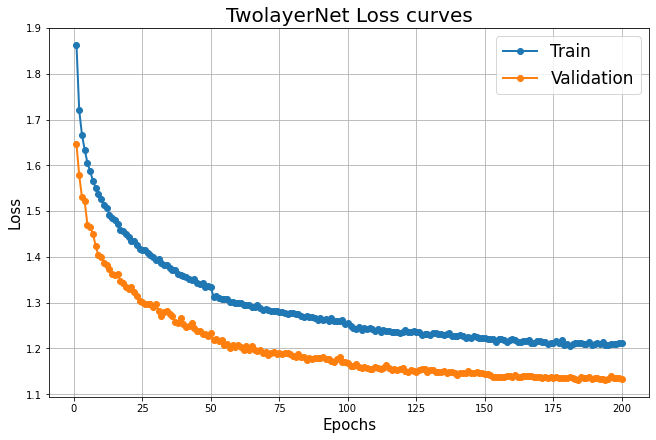

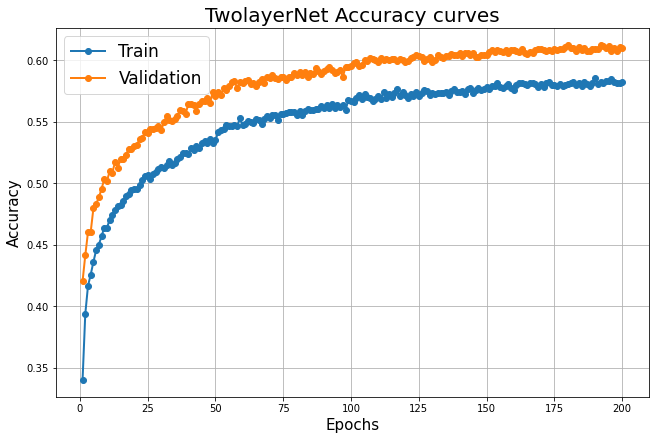

In [59]:
# finding best hyperparameters for TwoLayerNet (this cell only has the best found configuration)

train_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
    {
        "name": "RandomHorizontalFlip",
        "args": {"p": 0.5},
    },
    {
        "name": "GaussianBlur",
        "args": {"kernel_size": 3},
    },
]
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

network = "tln"
num_epochs = 200
batch_size = 128
opt_args = {"name": "Adam", "lr": 1e-4}
sch_args = {"name": "MultiStepLR", "milestones": [50, 100, 150], "gamma": 0.5}

tln_net, loss_fn = experiment(
    train_transforms, valid_transforms, network, num_epochs, batch_size, opt_args, sch_args=sch_args,
)

Selecting 40000 for train.
Selecting 10000 for valid.


Evaluate: Epoch [1/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 141.09it/s]                   


VALID 	: Summary: Loss: 1.6203 Accuracy: 0.4111
TRAIN 	: Summary: Loss: 1.8799 Accuracy: 0.3114


Evaluate: Epoch [2/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 126.18it/s]                   


VALID 	: Summary: Loss: 1.4934 Accuracy: 0.4527
TRAIN 	: Summary: Loss: 1.6283 Accuracy: 0.4081


Evaluate: Epoch [3/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.96it/s]                   


VALID 	: Summary: Loss: 1.4001 Accuracy: 0.4877
TRAIN 	: Summary: Loss: 1.5423 Accuracy: 0.4401


Evaluate: Epoch [4/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 146.22it/s]                   


VALID 	: Summary: Loss: 1.3516 Accuracy: 0.5030
TRAIN 	: Summary: Loss: 1.4877 Accuracy: 0.4607


Evaluate: Epoch [5/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 146.20it/s]                   


VALID 	: Summary: Loss: 1.3213 Accuracy: 0.5210
TRAIN 	: Summary: Loss: 1.4487 Accuracy: 0.4743


Evaluate: Epoch [6/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 136.33it/s]                   


VALID 	: Summary: Loss: 1.2923 Accuracy: 0.5360
TRAIN 	: Summary: Loss: 1.4130 Accuracy: 0.4895


Evaluate: Epoch [7/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.91it/s]                   


VALID 	: Summary: Loss: 1.2639 Accuracy: 0.5432
TRAIN 	: Summary: Loss: 1.3846 Accuracy: 0.4984


Evaluate: Epoch [8/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 136.13it/s]                   


VALID 	: Summary: Loss: 1.2330 Accuracy: 0.5524
TRAIN 	: Summary: Loss: 1.3538 Accuracy: 0.5127


Evaluate: Epoch [9/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 140.20it/s]                   


VALID 	: Summary: Loss: 1.2398 Accuracy: 0.5504
TRAIN 	: Summary: Loss: 1.3353 Accuracy: 0.5213


Evaluate: Epoch [10/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 140.49it/s]                  


VALID 	: Summary: Loss: 1.2046 Accuracy: 0.5631
TRAIN 	: Summary: Loss: 1.3068 Accuracy: 0.5320


Evaluate: Epoch [11/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 146.16it/s]                  


VALID 	: Summary: Loss: 1.1866 Accuracy: 0.5703
TRAIN 	: Summary: Loss: 1.2928 Accuracy: 0.5343


Evaluate: Epoch [12/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.66it/s]                  


VALID 	: Summary: Loss: 1.1525 Accuracy: 0.5872
TRAIN 	: Summary: Loss: 1.2766 Accuracy: 0.5413


Evaluate: Epoch [13/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.79it/s]                  


VALID 	: Summary: Loss: 1.1821 Accuracy: 0.5744
TRAIN 	: Summary: Loss: 1.2587 Accuracy: 0.5507


Evaluate: Epoch [14/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 138.57it/s]                  


VALID 	: Summary: Loss: 1.1652 Accuracy: 0.5867
TRAIN 	: Summary: Loss: 1.2412 Accuracy: 0.5544


Evaluate: Epoch [15/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.41it/s]                  


VALID 	: Summary: Loss: 1.1211 Accuracy: 0.5995
TRAIN 	: Summary: Loss: 1.2188 Accuracy: 0.5631


Evaluate: Epoch [16/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 130.36it/s]                  


VALID 	: Summary: Loss: 1.1323 Accuracy: 0.5992
TRAIN 	: Summary: Loss: 1.2109 Accuracy: 0.5663


Evaluate: Epoch [17/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 138.47it/s]                  


VALID 	: Summary: Loss: 1.1060 Accuracy: 0.6034
TRAIN 	: Summary: Loss: 1.2025 Accuracy: 0.5714


Evaluate: Epoch [18/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 148.21it/s]                  


VALID 	: Summary: Loss: 1.0914 Accuracy: 0.6065
TRAIN 	: Summary: Loss: 1.1823 Accuracy: 0.5756


Evaluate: Epoch [19/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 146.51it/s]                  


VALID 	: Summary: Loss: 1.0871 Accuracy: 0.6104
TRAIN 	: Summary: Loss: 1.1719 Accuracy: 0.5785


Evaluate: Epoch [20/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.93it/s]                  


VALID 	: Summary: Loss: 1.0692 Accuracy: 0.6228
TRAIN 	: Summary: Loss: 1.1598 Accuracy: 0.5843


Evaluate: Epoch [21/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.40it/s]                  


VALID 	: Summary: Loss: 1.0647 Accuracy: 0.6229
TRAIN 	: Summary: Loss: 1.1478 Accuracy: 0.5904


Evaluate: Epoch [22/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.82it/s]                  


VALID 	: Summary: Loss: 1.0582 Accuracy: 0.6244
TRAIN 	: Summary: Loss: 1.1366 Accuracy: 0.5949


Evaluate: Epoch [23/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.63it/s]                  


VALID 	: Summary: Loss: 1.0454 Accuracy: 0.6296
TRAIN 	: Summary: Loss: 1.1327 Accuracy: 0.5949


Evaluate: Epoch [24/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.59it/s]                  


VALID 	: Summary: Loss: 1.0409 Accuracy: 0.6296
TRAIN 	: Summary: Loss: 1.1205 Accuracy: 0.6011


Evaluate: Epoch [25/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.28it/s]                  


VALID 	: Summary: Loss: 1.0476 Accuracy: 0.6293
TRAIN 	: Summary: Loss: 1.1107 Accuracy: 0.6027


Evaluate: Epoch [26/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.46it/s]                  


VALID 	: Summary: Loss: 1.0327 Accuracy: 0.6338
TRAIN 	: Summary: Loss: 1.0990 Accuracy: 0.6083


Evaluate: Epoch [27/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.38it/s]                  


VALID 	: Summary: Loss: 1.0280 Accuracy: 0.6368
TRAIN 	: Summary: Loss: 1.0934 Accuracy: 0.6114


Evaluate: Epoch [28/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.98it/s]                  


VALID 	: Summary: Loss: 1.0062 Accuracy: 0.6449
TRAIN 	: Summary: Loss: 1.0893 Accuracy: 0.6121


Evaluate: Epoch [29/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.85it/s]                  


VALID 	: Summary: Loss: 1.0018 Accuracy: 0.6438
TRAIN 	: Summary: Loss: 1.0839 Accuracy: 0.6132


Evaluate: Epoch [30/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.75it/s]                  


VALID 	: Summary: Loss: 0.9941 Accuracy: 0.6490
TRAIN 	: Summary: Loss: 1.0682 Accuracy: 0.6208


Evaluate: Epoch [31/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.30it/s]                  


VALID 	: Summary: Loss: 1.0070 Accuracy: 0.6423
TRAIN 	: Summary: Loss: 1.0634 Accuracy: 0.6216


Evaluate: Epoch [32/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 140.07it/s]                  


VALID 	: Summary: Loss: 1.0264 Accuracy: 0.6384
TRAIN 	: Summary: Loss: 1.0592 Accuracy: 0.6235


Evaluate: Epoch [33/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.46it/s]                  


VALID 	: Summary: Loss: 0.9943 Accuracy: 0.6543
TRAIN 	: Summary: Loss: 1.0519 Accuracy: 0.6240


Evaluate: Epoch [34/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 140.49it/s]                  


VALID 	: Summary: Loss: 0.9839 Accuracy: 0.6548
TRAIN 	: Summary: Loss: 1.0469 Accuracy: 0.6272


Evaluate: Epoch [35/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.96it/s]                  


VALID 	: Summary: Loss: 1.0199 Accuracy: 0.6420
TRAIN 	: Summary: Loss: 1.0346 Accuracy: 0.6295


Evaluate: Epoch [36/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.01it/s]                  


VALID 	: Summary: Loss: 0.9936 Accuracy: 0.6460
TRAIN 	: Summary: Loss: 1.0301 Accuracy: 0.6344


Evaluate: Epoch [37/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 141.25it/s]                  


VALID 	: Summary: Loss: 0.9875 Accuracy: 0.6567
TRAIN 	: Summary: Loss: 1.0298 Accuracy: 0.6338


Evaluate: Epoch [38/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.92it/s]                  


VALID 	: Summary: Loss: 1.0057 Accuracy: 0.6503
TRAIN 	: Summary: Loss: 1.0167 Accuracy: 0.6385


Evaluate: Epoch [39/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 119.95it/s]                  


VALID 	: Summary: Loss: 0.9833 Accuracy: 0.6534
TRAIN 	: Summary: Loss: 1.0272 Accuracy: 0.6340


Evaluate: Epoch [40/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.89it/s]                  


VALID 	: Summary: Loss: 0.9812 Accuracy: 0.6573
TRAIN 	: Summary: Loss: 1.0121 Accuracy: 0.6379


Evaluate: Epoch [41/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.92it/s]                  


VALID 	: Summary: Loss: 0.9655 Accuracy: 0.6617
TRAIN 	: Summary: Loss: 1.0092 Accuracy: 0.6434


Evaluate: Epoch [42/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.34it/s]                  


VALID 	: Summary: Loss: 0.9667 Accuracy: 0.6558
TRAIN 	: Summary: Loss: 1.0031 Accuracy: 0.6440


Evaluate: Epoch [43/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.94it/s]                  


VALID 	: Summary: Loss: 0.9373 Accuracy: 0.6724
TRAIN 	: Summary: Loss: 1.0000 Accuracy: 0.6428


Evaluate: Epoch [44/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 140.12it/s]                  


VALID 	: Summary: Loss: 0.9367 Accuracy: 0.6692
TRAIN 	: Summary: Loss: 0.9971 Accuracy: 0.6478


Evaluate: Epoch [45/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 140.93it/s]                  


VALID 	: Summary: Loss: 0.9529 Accuracy: 0.6672
TRAIN 	: Summary: Loss: 0.9920 Accuracy: 0.6484


Evaluate: Epoch [46/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.80it/s]                  


VALID 	: Summary: Loss: 0.9533 Accuracy: 0.6682
TRAIN 	: Summary: Loss: 0.9914 Accuracy: 0.6480


Evaluate: Epoch [47/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.27it/s]                  


VALID 	: Summary: Loss: 0.9548 Accuracy: 0.6569
TRAIN 	: Summary: Loss: 0.9857 Accuracy: 0.6493


Evaluate: Epoch [48/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.86it/s]                  


VALID 	: Summary: Loss: 0.9701 Accuracy: 0.6637
TRAIN 	: Summary: Loss: 0.9791 Accuracy: 0.6515


Evaluate: Epoch [49/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.89it/s]                  


VALID 	: Summary: Loss: 0.9432 Accuracy: 0.6677
TRAIN 	: Summary: Loss: 0.9753 Accuracy: 0.6527


Evaluate: Epoch [50/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.13it/s]                  


VALID 	: Summary: Loss: 0.9484 Accuracy: 0.6679
TRAIN 	: Summary: Loss: 0.9755 Accuracy: 0.6555


Evaluate: Epoch [51/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.76it/s]                  


VALID 	: Summary: Loss: 0.9139 Accuracy: 0.6752
TRAIN 	: Summary: Loss: 0.9268 Accuracy: 0.6718


Evaluate: Epoch [52/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.63it/s]                  


VALID 	: Summary: Loss: 0.9136 Accuracy: 0.6777
TRAIN 	: Summary: Loss: 0.9173 Accuracy: 0.6761


Evaluate: Epoch [53/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.83it/s]                  


VALID 	: Summary: Loss: 0.9132 Accuracy: 0.6757
TRAIN 	: Summary: Loss: 0.9190 Accuracy: 0.6741


Evaluate: Epoch [54/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.21it/s]                  


VALID 	: Summary: Loss: 0.9154 Accuracy: 0.6798
TRAIN 	: Summary: Loss: 0.9162 Accuracy: 0.6729


Evaluate: Epoch [55/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 141.68it/s]                  


VALID 	: Summary: Loss: 0.9135 Accuracy: 0.6761
TRAIN 	: Summary: Loss: 0.9049 Accuracy: 0.6776


Evaluate: Epoch [56/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 141.98it/s]                  


VALID 	: Summary: Loss: 0.9143 Accuracy: 0.6811
TRAIN 	: Summary: Loss: 0.9149 Accuracy: 0.6774


Evaluate: Epoch [57/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.43it/s]                  


VALID 	: Summary: Loss: 0.9093 Accuracy: 0.6787
TRAIN 	: Summary: Loss: 0.9137 Accuracy: 0.6754


Evaluate: Epoch [58/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.02it/s]                  


VALID 	: Summary: Loss: 0.9099 Accuracy: 0.6789
TRAIN 	: Summary: Loss: 0.9039 Accuracy: 0.6784


Evaluate: Epoch [59/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.34it/s]                  


VALID 	: Summary: Loss: 0.9140 Accuracy: 0.6776
TRAIN 	: Summary: Loss: 0.9110 Accuracy: 0.6754


Evaluate: Epoch [60/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.85it/s]                  


VALID 	: Summary: Loss: 0.9115 Accuracy: 0.6792
TRAIN 	: Summary: Loss: 0.9068 Accuracy: 0.6784


Evaluate: Epoch [61/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.95it/s]                  


VALID 	: Summary: Loss: 0.9108 Accuracy: 0.6792
TRAIN 	: Summary: Loss: 0.9033 Accuracy: 0.6793


Evaluate: Epoch [62/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.95it/s]                  


VALID 	: Summary: Loss: 0.9101 Accuracy: 0.6760
TRAIN 	: Summary: Loss: 0.9016 Accuracy: 0.6786


Evaluate: Epoch [63/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.49it/s]                  


VALID 	: Summary: Loss: 0.9075 Accuracy: 0.6785
TRAIN 	: Summary: Loss: 0.9073 Accuracy: 0.6799


Evaluate: Epoch [64/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.41it/s]                  


VALID 	: Summary: Loss: 0.9094 Accuracy: 0.6780
TRAIN 	: Summary: Loss: 0.9076 Accuracy: 0.6781


Evaluate: Epoch [65/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.97it/s]                  


VALID 	: Summary: Loss: 0.9197 Accuracy: 0.6776
TRAIN 	: Summary: Loss: 0.9016 Accuracy: 0.6791


Evaluate: Epoch [66/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.23it/s]                  


VALID 	: Summary: Loss: 0.9145 Accuracy: 0.6753
TRAIN 	: Summary: Loss: 0.8975 Accuracy: 0.6808


Evaluate: Epoch [67/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.70it/s]                  


VALID 	: Summary: Loss: 0.9048 Accuracy: 0.6834
TRAIN 	: Summary: Loss: 0.8995 Accuracy: 0.6796


Evaluate: Epoch [68/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 141.64it/s]                  


VALID 	: Summary: Loss: 0.9073 Accuracy: 0.6813
TRAIN 	: Summary: Loss: 0.8960 Accuracy: 0.6799


Evaluate: Epoch [69/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.62it/s]                  


VALID 	: Summary: Loss: 0.9061 Accuracy: 0.6815
TRAIN 	: Summary: Loss: 0.8970 Accuracy: 0.6823


Evaluate: Epoch [70/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.07it/s]                  


VALID 	: Summary: Loss: 0.9089 Accuracy: 0.6784
TRAIN 	: Summary: Loss: 0.9004 Accuracy: 0.6818


Evaluate: Epoch [71/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.29it/s]                  


VALID 	: Summary: Loss: 0.9096 Accuracy: 0.6792
TRAIN 	: Summary: Loss: 0.8979 Accuracy: 0.6807


Evaluate: Epoch [72/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 141.48it/s]                  


VALID 	: Summary: Loss: 0.9097 Accuracy: 0.6775
TRAIN 	: Summary: Loss: 0.8924 Accuracy: 0.6825


Evaluate: Epoch [73/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 133.97it/s]                  


VALID 	: Summary: Loss: 0.9098 Accuracy: 0.6808
TRAIN 	: Summary: Loss: 0.8936 Accuracy: 0.6836


Evaluate: Epoch [74/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.10it/s]                  


VALID 	: Summary: Loss: 0.9145 Accuracy: 0.6787
TRAIN 	: Summary: Loss: 0.8947 Accuracy: 0.6825


Evaluate: Epoch [75/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.63it/s]                  


VALID 	: Summary: Loss: 0.9040 Accuracy: 0.6801
TRAIN 	: Summary: Loss: 0.8972 Accuracy: 0.6819


Evaluate: Epoch [76/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.36it/s]                  


VALID 	: Summary: Loss: 0.9113 Accuracy: 0.6790
TRAIN 	: Summary: Loss: 0.8980 Accuracy: 0.6803


Evaluate: Epoch [77/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 141.03it/s]                  


VALID 	: Summary: Loss: 0.9059 Accuracy: 0.6818
TRAIN 	: Summary: Loss: 0.8944 Accuracy: 0.6835


Evaluate: Epoch [78/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.01it/s]                  


VALID 	: Summary: Loss: 0.9057 Accuracy: 0.6792
TRAIN 	: Summary: Loss: 0.8939 Accuracy: 0.6818


Evaluate: Epoch [79/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.66it/s]                  


VALID 	: Summary: Loss: 0.9010 Accuracy: 0.6815
TRAIN 	: Summary: Loss: 0.8963 Accuracy: 0.6828


Evaluate: Epoch [80/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.77it/s]                  


VALID 	: Summary: Loss: 0.8986 Accuracy: 0.6832
TRAIN 	: Summary: Loss: 0.8879 Accuracy: 0.6848


Evaluate: Epoch [81/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.62it/s]                  


VALID 	: Summary: Loss: 0.9053 Accuracy: 0.6811
TRAIN 	: Summary: Loss: 0.8920 Accuracy: 0.6834


Evaluate: Epoch [82/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.36it/s]                  


VALID 	: Summary: Loss: 0.9102 Accuracy: 0.6789
TRAIN 	: Summary: Loss: 0.8919 Accuracy: 0.6845


Evaluate: Epoch [83/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.95it/s]                  


VALID 	: Summary: Loss: 0.9047 Accuracy: 0.6797
TRAIN 	: Summary: Loss: 0.8949 Accuracy: 0.6827


Evaluate: Epoch [84/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 132.69it/s]                  


VALID 	: Summary: Loss: 0.9001 Accuracy: 0.6828
TRAIN 	: Summary: Loss: 0.8881 Accuracy: 0.6854


Evaluate: Epoch [85/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.72it/s]                  


VALID 	: Summary: Loss: 0.9025 Accuracy: 0.6799
TRAIN 	: Summary: Loss: 0.8900 Accuracy: 0.6816


Evaluate: Epoch [86/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.94it/s]                  


VALID 	: Summary: Loss: 0.9041 Accuracy: 0.6804
TRAIN 	: Summary: Loss: 0.8889 Accuracy: 0.6868


Evaluate: Epoch [87/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.59it/s]                  


VALID 	: Summary: Loss: 0.9019 Accuracy: 0.6818
TRAIN 	: Summary: Loss: 0.8870 Accuracy: 0.6857


Evaluate: Epoch [88/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.05it/s]                  


VALID 	: Summary: Loss: 0.9038 Accuracy: 0.6841
TRAIN 	: Summary: Loss: 0.8869 Accuracy: 0.6844


Evaluate: Epoch [89/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.27it/s]                  


VALID 	: Summary: Loss: 0.9066 Accuracy: 0.6826
TRAIN 	: Summary: Loss: 0.8877 Accuracy: 0.6879


Evaluate: Epoch [90/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.72it/s]                  


VALID 	: Summary: Loss: 0.9038 Accuracy: 0.6806
TRAIN 	: Summary: Loss: 0.8898 Accuracy: 0.6837


Evaluate: Epoch [91/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.43it/s]                  


VALID 	: Summary: Loss: 0.9042 Accuracy: 0.6804
TRAIN 	: Summary: Loss: 0.8844 Accuracy: 0.6852


Evaluate: Epoch [92/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 136.59it/s]                  


VALID 	: Summary: Loss: 0.9068 Accuracy: 0.6810
TRAIN 	: Summary: Loss: 0.8856 Accuracy: 0.6849


Evaluate: Epoch [93/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 132.89it/s]                  


VALID 	: Summary: Loss: 0.9018 Accuracy: 0.6839
TRAIN 	: Summary: Loss: 0.8869 Accuracy: 0.6838


Evaluate: Epoch [94/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 140.74it/s]                  


VALID 	: Summary: Loss: 0.8991 Accuracy: 0.6826
TRAIN 	: Summary: Loss: 0.8845 Accuracy: 0.6846


Evaluate: Epoch [95/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 146.92it/s]                  


VALID 	: Summary: Loss: 0.9012 Accuracy: 0.6829
TRAIN 	: Summary: Loss: 0.8825 Accuracy: 0.6859


Evaluate: Epoch [96/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 138.48it/s]                  


VALID 	: Summary: Loss: 0.9039 Accuracy: 0.6848
TRAIN 	: Summary: Loss: 0.8835 Accuracy: 0.6877


Evaluate: Epoch [97/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 143.98it/s]                  


VALID 	: Summary: Loss: 0.8986 Accuracy: 0.6842
TRAIN 	: Summary: Loss: 0.8798 Accuracy: 0.6875


Evaluate: Epoch [98/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.01it/s]                  


VALID 	: Summary: Loss: 0.9035 Accuracy: 0.6776
TRAIN 	: Summary: Loss: 0.8852 Accuracy: 0.6860


Evaluate: Epoch [99/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 142.39it/s]                  


VALID 	: Summary: Loss: 0.9002 Accuracy: 0.6820
TRAIN 	: Summary: Loss: 0.8867 Accuracy: 0.6846


Evaluate: Epoch [100/100]: 100%|██████████████████████████████| 79/79 [00:00<00:00, 144.45it/s]                 


VALID 	: Summary: Loss: 0.9075 Accuracy: 0.6812
TRAIN 	: Summary: Loss: 0.8823 Accuracy: 0.6841
Finished Training


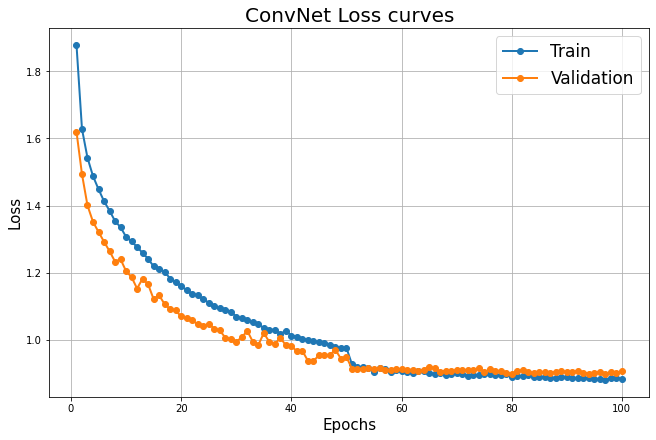

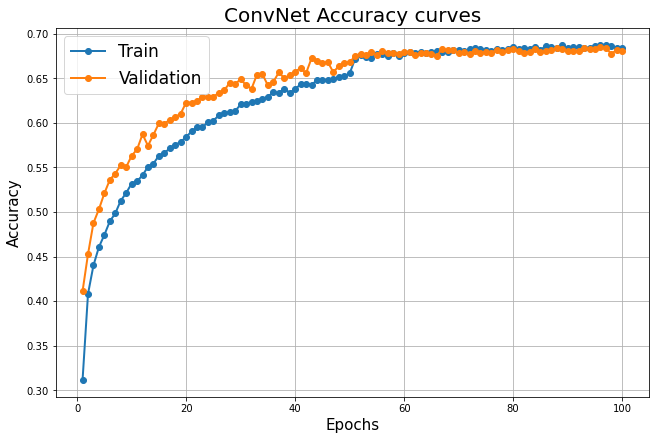

In [60]:
# finding best hyperparameters for ConvNet (this cell only has the best found configuration)

train_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
]
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

network = "cnn"
num_epochs = 100
batch_size = 128
opt_args = {"name": "Adam", "lr": 1e-3}

sch_args = None
sch_args = {"name": "MultiStepLR", "milestones": [50], "gamma": 0.1}

cnn_net, loss_fn = experiment(
    train_transforms, valid_transforms, network, num_epochs, batch_size, opt_args, sch_args=sch_args,
)

#### *` test the accuracy of ConvNet `*

In [63]:
# define the test dataset
test_transform = InputTransform(valid_transforms)
test_dataset = CIFAR(root="./datasets/CIFAR-10/", mode="test", transform=test_transform)
test_loader = get_dataloader(train_dataset, train=False, batch_size=128, num_workers=0)

In [64]:
valid(cnn_net, test_loader)
valid_class(cnn_net, test_loader, classes)

Accuracy of the network on the 10000 test images: 68 %
Accuracy of plane : 75 %
Accuracy of   car : 83 %
Accuracy of  bird : 65 %
Accuracy of   cat : 44 %
Accuracy of  deer : 65 %
Accuracy of   dog : 58 %
Accuracy of  frog : 73 %
Accuracy of horse : 70 %
Accuracy of  ship : 82 %
Accuracy of truck : 72 %


#### *`test the accuracy of TwolayerNet`*

In [65]:
valid(tln_net, test_loader)
valid_class(tln_net, test_loader, classes)

Accuracy of the network on the 10000 test images: 58 %
Accuracy of plane : 66 %
Accuracy of   car : 64 %
Accuracy of  bird : 40 %
Accuracy of   cat : 37 %
Accuracy of  deer : 53 %
Accuracy of   dog : 41 %
Accuracy of  frog : 69 %
Accuracy of horse : 69 %
Accuracy of  ship : 69 %
Accuracy of truck : 62 %


## Session 2:  Finetuning the ConvNet
### STL-10 DATASET
> The provided network is trained on a different dataset named CIFAR-10 , which
contains the images of 10 different object categories. The dataset we use throughout the assignment is a subset of STL-10 
with larger sizes and different object classes. So, there is a discrepancy between the
dataset we use to train (CIFAR-10) and test (STL-10) our network. One solution
would be to train the whole network from scratch. However, the number of param-
eters are too large to be trained properly with such few number of images provided.
One solution is to shift the learned weights in a way to perform well on the test
set, while preserving as much information as necessary from the training class.
### In this Session, extract 5 classes from STL training dataset , 
the the label of images can be defined as `{1: 'airplanes',2:'birds',3:'ships',4:'cats',5:'dogs'}`

#### *`Q3.1 create the STL10_Dataset `*

In [66]:
from stl10_input import read_all_images, read_labels


LABEL_MAP = {
    1 : "airplanes",
    2 : "birds",
    4 : "cats",
    6 : "dogs",
    9 : "ships",
}

LABEL_ENCODER = {
    1: 0,
    2: 1,
    4: 2,
    6: 3,
    9: 4,
}


class STL(Dataset):
    def __init__(self, root, mode, transform=None, encode_labels=False):
        self.root = root
        self.mode = mode
        self.train = self.mode in ["train", "valid"]
        self.transform = transform
        self.encode_labels = encode_labels

        self.load_data(root, mode)
        if self.train:
            self.select_samples()
        
        print(f":::: Loaded dataset from {root}: X ({self.data.shape}) y ({len(self.targets)})")

    def load_data(self, root, mode):
        fname_prefix = "train" if mode in ["valid", "train"] else "test"

        images_path = join(root, "stl10_binary", f"{fname_prefix}_X.bin")
        self.data = read_all_images(images_path)

        labels_path = join(root, "stl10_binary", f"{fname_prefix}_y.bin")
        self.targets = read_labels(labels_path)

        # only consider samples with relevant labels
        relevant_labels = np.array(list(LABEL_MAP.keys()))
        indices = np.where(np.in1d(self.targets, relevant_labels))[0]
        self.data = self.data[indices]
        self.targets = self.targets[indices].astype(int)

        if self.encode_labels:
            self.targets = np.array([LABEL_ENCODER[l] for l in self.targets])

    def select_samples(self, train_fraction=0.8, seed=0):
        np.random.seed(seed)

        num_train_samples = int(train_fraction * len(self.data))
        train_indices = np.random.choice(len(self.data), size=num_train_samples, replace=False)
        all_indices = np.arange(len(self.data))
        valid_indices = np.setdiff1d(all_indices, train_indices)

        if self.mode == "train":
            self.data = self.data[train_indices]
            self.targets = self.targets[train_indices]

        if self.mode == "valid":
            self.data = self.data[valid_indices]
            self.targets = self.targets[valid_indices]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        img, target = self.data[item], self.targets[item]
        if self.transform is not None:
            img = self.transform(img)
        return img, target

sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)


#### *`Q3.2  Finetuning from ConvNet & train the model and show the results`*

:::: Loaded dataset from ./datasets/STL-10/: X ((500, 96, 96, 3)) y (500)
:::: Loaded dataset from ./datasets/STL-10/: X ((2000, 96, 96, 3)) y (2000)
:::: Loaded dataset from ./datasets/STL-10/: X ((4000, 96, 96, 3)) y (4000)


Evaluate: Epoch [1/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 77.88it/s]                      


VALID 	: Summary: Loss: 1.6957 Accuracy: 0.2120
TRAIN 	: Summary: Loss: 1.7648 Accuracy: 0.2280


Evaluate: Epoch [2/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.31it/s]                      


VALID 	: Summary: Loss: 1.5403 Accuracy: 0.2820
TRAIN 	: Summary: Loss: 1.6038 Accuracy: 0.2860


Evaluate: Epoch [3/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.54it/s]                      


VALID 	: Summary: Loss: 1.4126 Accuracy: 0.3880
TRAIN 	: Summary: Loss: 1.4718 Accuracy: 0.3735


Evaluate: Epoch [4/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.59it/s]                      


VALID 	: Summary: Loss: 1.3090 Accuracy: 0.4280
TRAIN 	: Summary: Loss: 1.3614 Accuracy: 0.4320


Evaluate: Epoch [5/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.00it/s]                      


VALID 	: Summary: Loss: 1.2286 Accuracy: 0.4580
TRAIN 	: Summary: Loss: 1.2927 Accuracy: 0.4355


Evaluate: Epoch [6/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 78.71it/s]                      


VALID 	: Summary: Loss: 1.1715 Accuracy: 0.4800
TRAIN 	: Summary: Loss: 1.2303 Accuracy: 0.4625


Evaluate: Epoch [7/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 78.77it/s]                      


VALID 	: Summary: Loss: 1.1276 Accuracy: 0.5080
TRAIN 	: Summary: Loss: 1.1786 Accuracy: 0.4995


Evaluate: Epoch [8/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.96it/s]                      


VALID 	: Summary: Loss: 1.0982 Accuracy: 0.5200
TRAIN 	: Summary: Loss: 1.1457 Accuracy: 0.5035


Evaluate: Epoch [9/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.39it/s]                      


VALID 	: Summary: Loss: 1.0765 Accuracy: 0.5200
TRAIN 	: Summary: Loss: 1.1096 Accuracy: 0.5225


Evaluate: Epoch [10/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.68it/s]                     


VALID 	: Summary: Loss: 1.0553 Accuracy: 0.5400
TRAIN 	: Summary: Loss: 1.0913 Accuracy: 0.5315


Evaluate: Epoch [11/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.80it/s]                     


VALID 	: Summary: Loss: 1.0387 Accuracy: 0.5480
TRAIN 	: Summary: Loss: 1.0750 Accuracy: 0.5245


Evaluate: Epoch [12/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.32it/s]                     


VALID 	: Summary: Loss: 1.0230 Accuracy: 0.5500
TRAIN 	: Summary: Loss: 1.0474 Accuracy: 0.5545


Evaluate: Epoch [13/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.98it/s]                     


VALID 	: Summary: Loss: 1.0119 Accuracy: 0.5580
TRAIN 	: Summary: Loss: 1.0462 Accuracy: 0.5500


Evaluate: Epoch [14/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.26it/s]                     


VALID 	: Summary: Loss: 1.0012 Accuracy: 0.5740
TRAIN 	: Summary: Loss: 1.0265 Accuracy: 0.5540


Evaluate: Epoch [15/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.29it/s]                     


VALID 	: Summary: Loss: 0.9876 Accuracy: 0.5880
TRAIN 	: Summary: Loss: 1.0051 Accuracy: 0.5740


Evaluate: Epoch [16/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 77.72it/s]                     


VALID 	: Summary: Loss: 0.9768 Accuracy: 0.5960
TRAIN 	: Summary: Loss: 0.9980 Accuracy: 0.5800


Evaluate: Epoch [17/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 78.21it/s]                     


VALID 	: Summary: Loss: 0.9692 Accuracy: 0.6140
TRAIN 	: Summary: Loss: 0.9825 Accuracy: 0.5780


Evaluate: Epoch [18/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.84it/s]                     


VALID 	: Summary: Loss: 0.9551 Accuracy: 0.6180
TRAIN 	: Summary: Loss: 0.9801 Accuracy: 0.5935


Evaluate: Epoch [19/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 78.87it/s]                     


VALID 	: Summary: Loss: 0.9505 Accuracy: 0.6180
TRAIN 	: Summary: Loss: 0.9647 Accuracy: 0.5970


Evaluate: Epoch [20/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 74.47it/s]                     


VALID 	: Summary: Loss: 0.9441 Accuracy: 0.6160
TRAIN 	: Summary: Loss: 0.9435 Accuracy: 0.6090


Evaluate: Epoch [21/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.28it/s]                     


VALID 	: Summary: Loss: 0.9305 Accuracy: 0.6180
TRAIN 	: Summary: Loss: 0.9508 Accuracy: 0.5985


Evaluate: Epoch [22/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.06it/s]                     


VALID 	: Summary: Loss: 0.9233 Accuracy: 0.6340
TRAIN 	: Summary: Loss: 0.9352 Accuracy: 0.6000


Evaluate: Epoch [23/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 76.46it/s]                     


VALID 	: Summary: Loss: 0.9180 Accuracy: 0.6240
TRAIN 	: Summary: Loss: 0.9350 Accuracy: 0.6055


Evaluate: Epoch [24/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 77.62it/s]                     


VALID 	: Summary: Loss: 0.9096 Accuracy: 0.6240
TRAIN 	: Summary: Loss: 0.9148 Accuracy: 0.6175


Evaluate: Epoch [25/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.85it/s]                     


VALID 	: Summary: Loss: 0.9009 Accuracy: 0.6300
TRAIN 	: Summary: Loss: 0.9208 Accuracy: 0.6205


Evaluate: Epoch [26/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.16it/s]                     


VALID 	: Summary: Loss: 0.8997 Accuracy: 0.6320
TRAIN 	: Summary: Loss: 0.9128 Accuracy: 0.6225


Evaluate: Epoch [27/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 77.18it/s]                     


VALID 	: Summary: Loss: 0.8959 Accuracy: 0.6340
TRAIN 	: Summary: Loss: 0.8920 Accuracy: 0.6340


Evaluate: Epoch [28/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 78.55it/s]                     


VALID 	: Summary: Loss: 0.8838 Accuracy: 0.6480
TRAIN 	: Summary: Loss: 0.8921 Accuracy: 0.6215


Evaluate: Epoch [29/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.47it/s]                     


VALID 	: Summary: Loss: 0.8867 Accuracy: 0.6360
TRAIN 	: Summary: Loss: 0.8887 Accuracy: 0.6325


Evaluate: Epoch [30/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.29it/s]                     


VALID 	: Summary: Loss: 0.8748 Accuracy: 0.6540
TRAIN 	: Summary: Loss: 0.8770 Accuracy: 0.6380


Evaluate: Epoch [31/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.42it/s]                     


VALID 	: Summary: Loss: 0.8701 Accuracy: 0.6500
TRAIN 	: Summary: Loss: 0.8700 Accuracy: 0.6470


Evaluate: Epoch [32/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.53it/s]                     


VALID 	: Summary: Loss: 0.8663 Accuracy: 0.6480
TRAIN 	: Summary: Loss: 0.8590 Accuracy: 0.6440


Evaluate: Epoch [33/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.33it/s]                     


VALID 	: Summary: Loss: 0.8567 Accuracy: 0.6580
TRAIN 	: Summary: Loss: 0.8590 Accuracy: 0.6405


Evaluate: Epoch [34/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.62it/s]                     


VALID 	: Summary: Loss: 0.8604 Accuracy: 0.6620
TRAIN 	: Summary: Loss: 0.8550 Accuracy: 0.6575


Evaluate: Epoch [35/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.11it/s]                     


VALID 	: Summary: Loss: 0.8468 Accuracy: 0.6640
TRAIN 	: Summary: Loss: 0.8636 Accuracy: 0.6365


Evaluate: Epoch [36/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.51it/s]                     


VALID 	: Summary: Loss: 0.8423 Accuracy: 0.6680
TRAIN 	: Summary: Loss: 0.8512 Accuracy: 0.6585


Evaluate: Epoch [37/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.27it/s]                     


VALID 	: Summary: Loss: 0.8428 Accuracy: 0.6720
TRAIN 	: Summary: Loss: 0.8443 Accuracy: 0.6460


Evaluate: Epoch [38/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.32it/s]                     


VALID 	: Summary: Loss: 0.8416 Accuracy: 0.6780
TRAIN 	: Summary: Loss: 0.8315 Accuracy: 0.6650


Evaluate: Epoch [39/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.99it/s]                     


VALID 	: Summary: Loss: 0.8357 Accuracy: 0.6720
TRAIN 	: Summary: Loss: 0.8429 Accuracy: 0.6595


Evaluate: Epoch [40/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.12it/s]                     


VALID 	: Summary: Loss: 0.8276 Accuracy: 0.6820
TRAIN 	: Summary: Loss: 0.8333 Accuracy: 0.6615


Evaluate: Epoch [41/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.09it/s]                     


VALID 	: Summary: Loss: 0.8311 Accuracy: 0.6800
TRAIN 	: Summary: Loss: 0.8253 Accuracy: 0.6605


Evaluate: Epoch [42/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.50it/s]                     


VALID 	: Summary: Loss: 0.8231 Accuracy: 0.6820
TRAIN 	: Summary: Loss: 0.8287 Accuracy: 0.6565


Evaluate: Epoch [43/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.84it/s]                     


VALID 	: Summary: Loss: 0.8195 Accuracy: 0.6800
TRAIN 	: Summary: Loss: 0.8209 Accuracy: 0.6735


Evaluate: Epoch [44/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.94it/s]                     


VALID 	: Summary: Loss: 0.8166 Accuracy: 0.6880
TRAIN 	: Summary: Loss: 0.8146 Accuracy: 0.6630


Evaluate: Epoch [45/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 84.82it/s]                     


VALID 	: Summary: Loss: 0.8164 Accuracy: 0.6840
TRAIN 	: Summary: Loss: 0.8209 Accuracy: 0.6650


Evaluate: Epoch [46/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.97it/s]                     


VALID 	: Summary: Loss: 0.8201 Accuracy: 0.6880
TRAIN 	: Summary: Loss: 0.8051 Accuracy: 0.6760


Evaluate: Epoch [47/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.56it/s]                     


VALID 	: Summary: Loss: 0.8143 Accuracy: 0.6840
TRAIN 	: Summary: Loss: 0.8078 Accuracy: 0.6780


Evaluate: Epoch [48/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.36it/s]                     


VALID 	: Summary: Loss: 0.8115 Accuracy: 0.6800
TRAIN 	: Summary: Loss: 0.8195 Accuracy: 0.6555


Evaluate: Epoch [49/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.63it/s]                     


VALID 	: Summary: Loss: 0.8103 Accuracy: 0.6900
TRAIN 	: Summary: Loss: 0.7933 Accuracy: 0.6790


Evaluate: Epoch [50/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.21it/s]                     


VALID 	: Summary: Loss: 0.8065 Accuracy: 0.6840
TRAIN 	: Summary: Loss: 0.7798 Accuracy: 0.6815


Evaluate: Epoch [51/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 84.88it/s]                     


VALID 	: Summary: Loss: 0.8081 Accuracy: 0.6860
TRAIN 	: Summary: Loss: 0.8102 Accuracy: 0.6625


Evaluate: Epoch [52/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.78it/s]                     


VALID 	: Summary: Loss: 0.8003 Accuracy: 0.6880
TRAIN 	: Summary: Loss: 0.7919 Accuracy: 0.6865


Evaluate: Epoch [53/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 65.51it/s]                     


VALID 	: Summary: Loss: 0.8076 Accuracy: 0.6960
TRAIN 	: Summary: Loss: 0.7916 Accuracy: 0.6720


Evaluate: Epoch [54/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.20it/s]                     


VALID 	: Summary: Loss: 0.8002 Accuracy: 0.6940
TRAIN 	: Summary: Loss: 0.8014 Accuracy: 0.6780


Evaluate: Epoch [55/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.18it/s]                     


VALID 	: Summary: Loss: 0.7999 Accuracy: 0.6900
TRAIN 	: Summary: Loss: 0.7864 Accuracy: 0.6770


Evaluate: Epoch [56/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.54it/s]                     


VALID 	: Summary: Loss: 0.7956 Accuracy: 0.6940
TRAIN 	: Summary: Loss: 0.7846 Accuracy: 0.6800


Evaluate: Epoch [57/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.54it/s]                     


VALID 	: Summary: Loss: 0.7921 Accuracy: 0.6900
TRAIN 	: Summary: Loss: 0.7722 Accuracy: 0.6925


Evaluate: Epoch [58/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.20it/s]                     


VALID 	: Summary: Loss: 0.7937 Accuracy: 0.6940
TRAIN 	: Summary: Loss: 0.7720 Accuracy: 0.6865


Evaluate: Epoch [59/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.21it/s]                     


VALID 	: Summary: Loss: 0.7956 Accuracy: 0.6900
TRAIN 	: Summary: Loss: 0.7831 Accuracy: 0.6820


Evaluate: Epoch [60/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.50it/s]                     


VALID 	: Summary: Loss: 0.7948 Accuracy: 0.6880
TRAIN 	: Summary: Loss: 0.7730 Accuracy: 0.6725


Evaluate: Epoch [61/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.53it/s]                     


VALID 	: Summary: Loss: 0.7914 Accuracy: 0.6940
TRAIN 	: Summary: Loss: 0.7853 Accuracy: 0.6835


Evaluate: Epoch [62/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.12it/s]                     


VALID 	: Summary: Loss: 0.7886 Accuracy: 0.6900
TRAIN 	: Summary: Loss: 0.7778 Accuracy: 0.6810


Evaluate: Epoch [63/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.07it/s]                     


VALID 	: Summary: Loss: 0.7834 Accuracy: 0.6960
TRAIN 	: Summary: Loss: 0.7551 Accuracy: 0.6875


Evaluate: Epoch [64/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.99it/s]                     


VALID 	: Summary: Loss: 0.7896 Accuracy: 0.7000
TRAIN 	: Summary: Loss: 0.7645 Accuracy: 0.6910


Evaluate: Epoch [65/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.45it/s]                     


VALID 	: Summary: Loss: 0.7849 Accuracy: 0.6980
TRAIN 	: Summary: Loss: 0.7725 Accuracy: 0.6845


Evaluate: Epoch [66/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.10it/s]                     


VALID 	: Summary: Loss: 0.7862 Accuracy: 0.6940
TRAIN 	: Summary: Loss: 0.7708 Accuracy: 0.6900


Evaluate: Epoch [67/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.88it/s]                     


VALID 	: Summary: Loss: 0.7788 Accuracy: 0.7040
TRAIN 	: Summary: Loss: 0.7647 Accuracy: 0.6935


Evaluate: Epoch [68/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 78.77it/s]                     


VALID 	: Summary: Loss: 0.7781 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7714 Accuracy: 0.6785


Evaluate: Epoch [69/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.84it/s]                     


VALID 	: Summary: Loss: 0.7764 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7469 Accuracy: 0.7035


Evaluate: Epoch [70/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.64it/s]                     


VALID 	: Summary: Loss: 0.7814 Accuracy: 0.7080
TRAIN 	: Summary: Loss: 0.7405 Accuracy: 0.7005


Evaluate: Epoch [71/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.43it/s]                     


VALID 	: Summary: Loss: 0.7711 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7554 Accuracy: 0.6875


Evaluate: Epoch [72/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.16it/s]                     


VALID 	: Summary: Loss: 0.7808 Accuracy: 0.6900
TRAIN 	: Summary: Loss: 0.7475 Accuracy: 0.6975


Evaluate: Epoch [73/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.62it/s]                     


VALID 	: Summary: Loss: 0.7723 Accuracy: 0.7100
TRAIN 	: Summary: Loss: 0.7543 Accuracy: 0.6975


Evaluate: Epoch [74/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.93it/s]                     


VALID 	: Summary: Loss: 0.7790 Accuracy: 0.6980
TRAIN 	: Summary: Loss: 0.7521 Accuracy: 0.6835


Evaluate: Epoch [75/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.22it/s]                     


VALID 	: Summary: Loss: 0.7761 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7543 Accuracy: 0.6930


Evaluate: Epoch [76/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.75it/s]                     


VALID 	: Summary: Loss: 0.7704 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7538 Accuracy: 0.6875


Evaluate: Epoch [77/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.42it/s]                     


VALID 	: Summary: Loss: 0.7736 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7367 Accuracy: 0.6990


Evaluate: Epoch [78/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.25it/s]                     


VALID 	: Summary: Loss: 0.7714 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7577 Accuracy: 0.7010


Evaluate: Epoch [79/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.53it/s]                     


VALID 	: Summary: Loss: 0.7788 Accuracy: 0.6980
TRAIN 	: Summary: Loss: 0.7203 Accuracy: 0.7065


Evaluate: Epoch [80/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.72it/s]                     


VALID 	: Summary: Loss: 0.7713 Accuracy: 0.7080
TRAIN 	: Summary: Loss: 0.7470 Accuracy: 0.6965


Evaluate: Epoch [81/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.29it/s]                     


VALID 	: Summary: Loss: 0.7732 Accuracy: 0.7060
TRAIN 	: Summary: Loss: 0.7333 Accuracy: 0.7040


Evaluate: Epoch [82/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.42it/s]                     


VALID 	: Summary: Loss: 0.7704 Accuracy: 0.7080
TRAIN 	: Summary: Loss: 0.7328 Accuracy: 0.7050


Evaluate: Epoch [83/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.94it/s]                     


VALID 	: Summary: Loss: 0.7708 Accuracy: 0.7120
TRAIN 	: Summary: Loss: 0.7399 Accuracy: 0.7095


Evaluate: Epoch [84/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.56it/s]                     


VALID 	: Summary: Loss: 0.7705 Accuracy: 0.7040
TRAIN 	: Summary: Loss: 0.7382 Accuracy: 0.6930


Evaluate: Epoch [85/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.16it/s]                     


VALID 	: Summary: Loss: 0.7683 Accuracy: 0.7060
TRAIN 	: Summary: Loss: 0.7354 Accuracy: 0.7070


Evaluate: Epoch [86/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.65it/s]                     


VALID 	: Summary: Loss: 0.7729 Accuracy: 0.7120
TRAIN 	: Summary: Loss: 0.7339 Accuracy: 0.6925


Evaluate: Epoch [87/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.49it/s]                     


VALID 	: Summary: Loss: 0.7721 Accuracy: 0.7060
TRAIN 	: Summary: Loss: 0.7190 Accuracy: 0.7120


Evaluate: Epoch [88/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.59it/s]                     


VALID 	: Summary: Loss: 0.7690 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7309 Accuracy: 0.7120


Evaluate: Epoch [89/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.78it/s]                     


VALID 	: Summary: Loss: 0.7629 Accuracy: 0.7000
TRAIN 	: Summary: Loss: 0.7223 Accuracy: 0.7110


Evaluate: Epoch [90/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.22it/s]                     


VALID 	: Summary: Loss: 0.7633 Accuracy: 0.7080
TRAIN 	: Summary: Loss: 0.7158 Accuracy: 0.7100


Evaluate: Epoch [91/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.69it/s]                     


VALID 	: Summary: Loss: 0.7650 Accuracy: 0.7020
TRAIN 	: Summary: Loss: 0.7137 Accuracy: 0.7165


Evaluate: Epoch [92/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.90it/s]                     


VALID 	: Summary: Loss: 0.7665 Accuracy: 0.6960
TRAIN 	: Summary: Loss: 0.7124 Accuracy: 0.7075


Evaluate: Epoch [93/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.41it/s]                     


VALID 	: Summary: Loss: 0.7652 Accuracy: 0.6980
TRAIN 	: Summary: Loss: 0.7061 Accuracy: 0.7065


Evaluate: Epoch [94/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.42it/s]                     


VALID 	: Summary: Loss: 0.7674 Accuracy: 0.7000
TRAIN 	: Summary: Loss: 0.6966 Accuracy: 0.7155


Evaluate: Epoch [95/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.18it/s]                     


VALID 	: Summary: Loss: 0.7704 Accuracy: 0.6980
TRAIN 	: Summary: Loss: 0.7140 Accuracy: 0.7000


Evaluate: Epoch [96/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.65it/s]                     


VALID 	: Summary: Loss: 0.7651 Accuracy: 0.6880
TRAIN 	: Summary: Loss: 0.7250 Accuracy: 0.7000


Evaluate: Epoch [97/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.06it/s]                     


VALID 	: Summary: Loss: 0.7670 Accuracy: 0.7080
TRAIN 	: Summary: Loss: 0.7119 Accuracy: 0.7040


Evaluate: Epoch [98/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.80it/s]                     


VALID 	: Summary: Loss: 0.7625 Accuracy: 0.6980
TRAIN 	: Summary: Loss: 0.7091 Accuracy: 0.7080


Evaluate: Epoch [99/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.82it/s]                     


VALID 	: Summary: Loss: 0.7604 Accuracy: 0.7000
TRAIN 	: Summary: Loss: 0.6897 Accuracy: 0.7315


Evaluate: Epoch [100/100]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.54it/s]                    


VALID 	: Summary: Loss: 0.7668 Accuracy: 0.6900
TRAIN 	: Summary: Loss: 0.7184 Accuracy: 0.7080
Finished Training


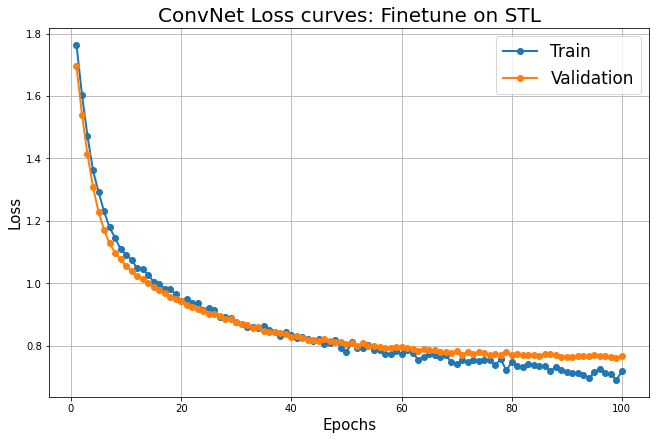

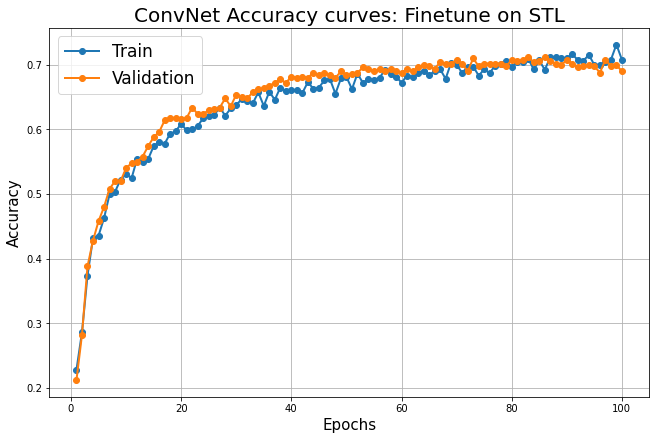

Evaluate: Epoch [1/1]: 100%|██████████████████████████████| 32/32 [00:00<00:00, 79.97it/s]                      

TEST 	: Summary: Loss: 0.7493 Accuracy: 0.6990


(0.7493223370984197, 0.699)

In [67]:
# we tried a bunch of experiments and only retain the best configuration here

fix_seed(0)

# define network
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="./checkpoints/cnn_best_hparams.pt",
    return_features=False,
)

# define transforms
train_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
    {
        "name": "RandomAffine",
        "args": {"degrees": 10, "translate": (0.1, 0.1), "scale": (0.8, 1.2)},
    },
]
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
test_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

num_epochs = 100
batch_size = 128

# define the datasets
valid_transform = InputTransform(valid_transforms)
valid_dataset = STL(root="./datasets/STL-10/", mode="valid", transform=valid_transform, encode_labels=True)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=batch_size, num_workers=0)

train_transform = InputTransform(train_transforms)
train_dataset = STL(root="./datasets/STL-10/", mode="train", transform=train_transform, encode_labels=True)
train_loader = get_dataloader(train_dataset, train=True, batch_size=batch_size, num_workers=0)

test_transform = InputTransform(test_transforms)
test_dataset = STL(root="./datasets/STL-10/", mode="test", transform=test_transform, encode_labels=True)
test_loader = get_dataloader(test_dataset, train=False, batch_size=batch_size, num_workers=0)

# define the optimizer and scheduler
opt_args = {"name": "Adam", "lr": 1e-4}

sch_args = None
# sch_args = {"name": "MultiStepLR", "milestones": [50], "gamma": 0.1}

opt = optimizer(model_params=net.parameters(), **opt_args)
sch = None
if sch_args is not None:
    sch = scheduler(opt=opt, **sch_args)
    
# define the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs, train_losses, train_metrics, valid_losses, valid_metrics = train(
    net, loss_fn, train_loader, valid_loader, num_epochs=num_epochs, opt=opt, sch=sch,
)

arch = type(net).__name__

# plot training curves
plot_multiple_quantities_by_time(
    quantities=[train_losses["loss"], valid_losses["loss"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Loss curves: Finetune on STL",
    show=True,
    save=False,
    save_path="../results/cnn_finetuning_loss_plot_default.png",
    ylabel="Loss",
)
plot_multiple_quantities_by_time(
    quantities=[train_metrics["accuracy"], valid_metrics["accuracy"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Accuracy curves: Finetune on STL",
    show=True,
    save=False,
    save_path="../results/cnn_finetuning_accu_plot_default.png",
    ylabel="Accuracy",
)

N = net.eval()
evaluate(N, test_loader, nn.CrossEntropyLoss(), 1, 1, mode="test")

In [70]:
valid(N, test_loader)

stl_classes = list(LABEL_MAP.values())
valid_class(N, test_loader, stl_classes)

Accuracy of the network on the 10000 test images: 69 %
Accuracy of airplanes : 83 %
Accuracy of birds : 50 %
Accuracy of  cats : 50 %
Accuracy of  dogs : 48 %
Accuracy of ships : 81 %


In [61]:
# additional stuff like `linear probing`, `visualizing features` etc was done in `experiments/cnn_finetuning_improvment.ipynb`

###  `Bonus`

In [62]:
# additional stuff for performance improvement was done in `experiments/cnn_finetuning_improvment.ipynb`
# the best result configuration is given in the previous cell anyways